In [5]:
# -----------------------------
# Função geradora (já OK)
# -----------------------------
import numpy as np
import pickle
from mlquantify.utils.method import MoSS

def gerar_distribuicoes_moss_duplo(
    n_samples=1000,
    n_prevalences=50,
    n_merges=10,
    n_curves=200,
    save_path="synthetic_distributions.pkl"
):
    alphas = np.linspace(0.01, 0.99, n_prevalences)
    merges = np.linspace(0.0, 1.0, n_merges)
    synthetic_distributions = {}
    total = len(alphas) * len(merges)
    count = 0

    for alpha in alphas:
        for merge in merges:
            all_curves = []
            for _ in range(n_curves):
                syn_pos, syn_neg = MoSS(n_samples, alpha, merge)  # assinatura: (n_samples, alpha, merge)
                syn_scores = np.concatenate([syn_pos, syn_neg])
                all_curves.append(syn_scores)
            # chave é tupla (alpha, merge)
            synthetic_distributions[(round(alpha, 3), round(merge, 3))] = all_curves
            count += 1
            if count % 10 == 0:
                print(f"Progresso: {count}/{total} combinações geradas...")

    with open(save_path, "wb") as f:
        pickle.dump(synthetic_distributions, f)

    print(f"✅ {total} combinações (alpha × merge), cada uma com {n_curves} curvas salvas em {save_path}")
    return synthetic_distributions

# Exemplo de chamada (ajuste conforme sua máquina)
synthetic_distributions = gerar_distribuicoes_moss_duplo(n_samples=1000, n_prevalences=30, n_merges=6, n_curves=100)

Progresso: 10/180 combinações geradas...
Progresso: 20/180 combinações geradas...
Progresso: 30/180 combinações geradas...
Progresso: 40/180 combinações geradas...
Progresso: 50/180 combinações geradas...
Progresso: 60/180 combinações geradas...
Progresso: 70/180 combinações geradas...
Progresso: 80/180 combinações geradas...
Progresso: 90/180 combinações geradas...
Progresso: 100/180 combinações geradas...
Progresso: 110/180 combinações geradas...
Progresso: 120/180 combinações geradas...
Progresso: 130/180 combinações geradas...
Progresso: 140/180 combinações geradas...
Progresso: 150/180 combinações geradas...
Progresso: 160/180 combinações geradas...
Progresso: 170/180 combinações geradas...
Progresso: 180/180 combinações geradas...
✅ 180 combinações (alpha × merge), cada uma com 100 curvas salvas em synthetic_distributions.pkl


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, entropy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from mlquantify.methods.aggregative import DySsyn
import quapy as qp
import pickle
import warnings
from typing import Protocol

warnings.filterwarnings("ignore")

# ===========================
# ===== Funções base ========
# ===========================

def extract_features(scores):
    features = {
        'mean': np.mean(scores),
        'var': np.var(scores),
        'skew': skew(scores),
        'kurt': kurtosis(scores),
        'q10': np.quantile(scores, 0.1),
        'q25': np.quantile(scores, 0.25),
        'q50': np.quantile(scores, 0.5),
        'q75': np.quantile(scores, 0.75),
        'q90': np.quantile(scores, 0.9)
    }
    hist, _ = np.histogram(scores, bins=20, density=True)
    hist = hist + 1e-12
    features['entropy'] = entropy(hist)
    return features


def generate_artificial_prevalences(n_dim, n_prev=19, n_iter=1):
    if n_dim != 2:
        raise NotImplementedError("Apenas binário por enquanto.")
    prevalences = np.linspace(0.05, 0.95, n_prev)
    combos = [[1-p, p] for p in prevalences]
    return combos * n_iter


def get_indexes_with_prevalence(y, prevalence, batch_size):
    pos_idx = np.where(y == 1)[0]
    neg_idx = np.where(y == 0)[0]
    n_pos = int(batch_size * prevalence[1])
    n_neg = batch_size - n_pos
    pos_sel = np.random.choice(pos_idx, size=n_pos, replace=True)
    neg_sel = np.random.choice(neg_idx, size=n_neg, replace=True)
    idx = np.concatenate([pos_sel, neg_sel])
    np.random.shuffle(idx)
    return idx


class APP(Protocol):
    def __init__(self, batch_size, n_prevalences, repeats=1, random_state=None):
        self.batch_size = batch_size if isinstance(batch_size, list) else [batch_size]
        self.n_prevalences = n_prevalences
        self.repeats = repeats
        self.random_state = random_state
        if random_state is not None:
            np.random.seed(random_state)

    def split(self, X, y):
        n_dim = len(np.unique(y))
        for batch_size in self.batch_size:
            prevalences = generate_artificial_prevalences(n_dim, self.n_prevalences, self.repeats)
            for prev in prevalences:
                idx = get_indexes_with_prevalence(y, prev, batch_size)
                yield idx, prev


# ===========================
# ===== Treino Regressor ====
# ===========================

with open("synthetic_distributions.pkl", "rb") as f:
    synthetic_distributions = pickle.load(f)

X_features, y_labels = [], []
for p, curves in synthetic_distributions.items():
    all_scores = np.concatenate(curves) if isinstance(curves, list) else curves
    feats = extract_features(all_scores)
    X_features.append(list(feats.values()))
    y_labels.append(p)

X_features = np.array(X_features)
y_labels = np.array(y_labels)

reg = RandomForestRegressor(n_estimators=300, random_state=42)
reg.fit(X_features, y_labels)


# ===========================
# ===== Avaliação APP =======
# ===========================

def avaliar_dataset_APP(nome, X, y, app_protocol):
    if len(np.unique(y)) > 2:
        y = (y == np.max(y)).astype(int)

    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.5, random_state=42, stratify=y
    )

    clf = RandomForestClassifier(n_estimators=300, random_state=42)
    clf.fit(X_train, y_train)

    dyssin_model = DySsyn(RandomForestClassifier(n_estimators=300, random_state=42))
    dyssin_model.fit(X_train, y_train)

    resultados = []
    for idx, prev in app_protocol.split(X_test, y_test):
        X_batch, y_batch = X_test[idx], y_test[idx]
        real_prev = np.mean(y_batch)
        scores = clf.predict_proba(X_batch)[:, 1]

        feats = np.array(list(extract_features(scores).values())).reshape(1, -1)
        pred_prev_reg = reg.predict(feats)[0]
        pred_prev_dyssin = dyssin_model.predict(X_batch)[1]

        resultados.append({
            "Dataset": nome,
            "Prev_Real": real_prev,
            "Prev_Alvo": prev[1],
            "Regressor": pred_prev_reg,
            "DySsyn": pred_prev_dyssin,
            "Erro_Regressor": abs(real_prev - pred_prev_reg),
            "Erro_DySsyn": abs(real_prev - pred_prev_dyssin)
        })

    return pd.DataFrame(resultados)


# ===========================
# ===== Rodar Experimentos ===
# ===========================

datasets_names = [
    "balance.1", "balance.3", "breast-cancer",
    "cmc.1", "cmc.2", "cmc.3", "ctg.1", "ctg.2", "ctg.3", "german",
    "haberman", "ionosphere", "iris.2", "iris.3", "mammographic",
    "pageblocks.5", "semeion", "sonar", "spambase", "spectf",
    "tictactoe", "transfusion", "wdbc", "wine.1", "wine.2",
    "wine.3", "wine-q-red", "wine-q-white", "yeast"
]

app = APP(batch_size=200, n_prevalences=19, repeats=2, random_state=42)

resultados_detalhados = []
resumo_final = []

for nome in datasets_names:
    try:
        print(f"\n🔍 Carregando dataset QuaPy: {nome}")
        dataset = qp.datasets.fetch_UCIBinaryDataset(nome)

        X_train, y_train = dataset.training.X, dataset.training.y
        X_test, y_test = dataset.test.X, dataset.test.y

        X = np.vstack([X_train, X_test])
        y = np.concatenate([y_train, y_test])
        X = np.array(X)
        y = np.array(y).ravel()

        print(f"✅ Rodando APP no dataset {nome}")
        df_app = avaliar_dataset_APP(nome, X, y, app)

        resultados_detalhados.append(df_app)

        mean_errors = df_app[["Erro_Regressor", "Erro_DySsyn"]].mean()
        resumo_final.append({
            "Dataset": nome,
            "Erro Médio Regressor": mean_errors["Erro_Regressor"],
            "Erro Médio DySsyn": mean_errors["Erro_DySsyn"]
        })

    except Exception as e:
        print(f"❌ Erro no dataset {nome}: {e}")

# ---- Salvar ----
df_detalhado = pd.concat(resultados_detalhados, ignore_index=True)
df_resumo = pd.DataFrame(resumo_final)

df_detalhado.to_csv("resultados_APP_detalhado.csv", index=False)
df_resumo.to_csv("resultados_APP_resumo.csv", index=False)

print("\n===== RESULTADOS SALVOS =====")
print("📄 resultados_APP_detalhado.csv → 1 linha por prevalência")
print("📄 resultados_APP_resumo.csv → 1 linha por dataset (média dos erros)")

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, entropy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from mlquantify.methods.aggregative import DySsyn
import quapy as qp
import pickle
import warnings
from typing import Protocol

warnings.filterwarnings("ignore")

# ===========================
# ===== Funções base ========
# ===========================

def extract_features(scores):
    features = {
        'mean': np.mean(scores),
        'var': np.var(scores),
        'skew': skew(scores),
        'kurt': kurtosis(scores),
        'q10': np.quantile(scores, 0.1),
        'q25': np.quantile(scores, 0.25),
        'q50': np.quantile(scores, 0.5),
        'q75': np.quantile(scores, 0.75),
        'q90': np.quantile(scores, 0.9)
    }
    hist, _ = np.histogram(scores, bins=20, density=True)
    hist = hist + 1e-12
    features['entropy'] = entropy(hist)
    return features


def generate_artificial_prevalences(n_dim, n_prev=19, n_iter=1):
    if n_dim != 2:
        raise NotImplementedError("Apenas binário por enquanto.")
    prevalences = np.linspace(0.05, 0.95, n_prev)
    combos = [[1-p, p] for p in prevalences]
    return combos * n_iter


def get_indexes_with_prevalence(y, prevalence, batch_size):
    pos_idx = np.where(y == 1)[0]
    neg_idx = np.where(y == 0)[0]
    n_pos = int(batch_size * prevalence[1])
    n_neg = batch_size - n_pos
    pos_sel = np.random.choice(pos_idx, size=n_pos, replace=True)
    neg_sel = np.random.choice(neg_idx, size=n_neg, replace=True)
    idx = np.concatenate([pos_sel, neg_sel])
    np.random.shuffle(idx)
    return idx


class APP(Protocol):
    def __init__(self, batch_size, n_prevalences, repeats=1, random_state=None):
        self.batch_size = batch_size if isinstance(batch_size, list) else [batch_size]
        self.n_prevalences = n_prevalences
        self.repeats = repeats
        self.random_state = random_state
        if random_state is not None:
            np.random.seed(random_state)

    def split(self, X, y):
        n_dim = len(np.unique(y))
        for batch_size in self.batch_size:
            prevalences = generate_artificial_prevalences(n_dim, self.n_prevalences, self.repeats)
            for prev in prevalences:
                idx = get_indexes_with_prevalence(y, prev, batch_size)
                yield idx, prev


# ===========================
# ===== Treino Regressor ====
# ===========================

with open("synthetic_distributions.pkl", "rb") as f:
    synthetic_distributions = pickle.load(f)

X_features, y_labels = [], []
for key, curves in synthetic_distributions.items():
    all_scores = np.concatenate(curves) if isinstance(curves, list) else curves
    feats = extract_features(all_scores)
    X_features.append(list(feats.values()))

    # Usa apenas a prevalência (alpha)
    if isinstance(key, tuple):
        y_labels.append(key[0])  # alpha
    else:
        y_labels.append(key)

X_features = np.array(X_features)
y_labels = np.array(y_labels)

reg = RandomForestRegressor(n_estimators=300, random_state=42)
reg.fit(X_features, y_labels)


# ===========================
# ===== Avaliação APP =======
# ===========================

def avaliar_dataset_APP(nome, X, y, app_protocol):
    if len(np.unique(y)) > 2:
        y = (y == np.max(y)).astype(int)

    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.5, random_state=42, stratify=y
    )

    clf = RandomForestClassifier(n_estimators=300, random_state=42)
    clf.fit(X_train, y_train)

    dyssin_model = DySsyn(RandomForestClassifier(n_estimators=300, random_state=42))
    dyssin_model.fit(X_train, y_train)

    resultados = []
    for idx, prev in app_protocol.split(X_test, y_test):
        X_batch, y_batch = X_test[idx], y_test[idx]
        real_prev = np.mean(y_batch)
        scores = clf.predict_proba(X_batch)[:, 1]

        feats = np.array(list(extract_features(scores).values())).reshape(1, -1)
        pred_prev_reg = reg.predict(feats)[0]
        pred_prev_dyssin = dyssin_model.predict(X_batch)[1]

        resultados.append({
            "Dataset": nome,
            "Prev_Real": real_prev,
            "Prev_Alvo": prev[1],
            "Regressor": pred_prev_reg,
            "DySsyn": pred_prev_dyssin,
            "Erro_Regressor": abs(real_prev - pred_prev_reg),
            "Erro_DySsyn": abs(real_prev - pred_prev_dyssin)
        })

    return pd.DataFrame(resultados)


# ===========================
# ===== Rodar Experimentos ===
# ===========================

datasets_names = [
    "balance.1", "balance.3", "breast-cancer",
    "cmc.1", "cmc.2", "cmc.3", "ctg.1", "ctg.2", "ctg.3", "german",
    "haberman", "ionosphere", "iris.2", "iris.3", "mammographic",
    "pageblocks.5", "semeion", "sonar", "spambase", "spectf",
    "tictactoe", "transfusion", "wdbc", "wine.1", "wine.2",
    "wine.3", "wine-q-red", "wine-q-white", "yeast"
]

app = APP(batch_size=200, n_prevalences=19, repeats=2, random_state=42)

resultados_detalhados = []
resumo_final = []

for nome in datasets_names:
    try:
        print(f"\n🔍 Carregando dataset QuaPy: {nome}")
        dataset = qp.datasets.fetch_UCIBinaryDataset(nome)

        X_train, y_train = dataset.training.X, dataset.training.y
        X_test, y_test = dataset.test.X, dataset.test.y

        X = np.vstack([X_train, X_test])
        y = np.concatenate([y_train, y_test])
        X = np.array(X)
        y = np.array(y).ravel()

        print(f"✅ Rodando APP no dataset {nome}")
        df_app = avaliar_dataset_APP(nome, X, y, app)

        resultados_detalhados.append(df_app)

        mean_errors = df_app[["Erro_Regressor", "Erro_DySsyn"]].mean()
        resumo_final.append({
            "Dataset": nome,
            "Erro Médio Regressor": mean_errors["Erro_Regressor"],
            "Erro Médio DySsyn": mean_errors["Erro_DySsyn"]
        })

    except Exception as e:
        print(f"❌ Erro no dataset {nome}: {e}")

# ---- Salvar ----
df_detalhado = pd.concat(resultados_detalhados, ignore_index=True)
df_resumo = pd.DataFrame(resumo_final)

df_detalhado.to_csv("resultados_APP_detalhado.csv", index=False)
df_resumo.to_csv("resultados_APP_resumo.csv", index=False)

print("\n===== RESULTADOS SALVOS =====")
print("📄 resultados_APP_detalhado.csv → 1 linha por prevalência")
print("📄 resultados_APP_resumo.csv → 1 linha por dataset (média dos erros)")


🔍 Carregando dataset QuaPy: balance.1
✅ Rodando APP no dataset balance.1

🔍 Carregando dataset QuaPy: balance.3
✅ Rodando APP no dataset balance.3

🔍 Carregando dataset QuaPy: breast-cancer
✅ Rodando APP no dataset breast-cancer

🔍 Carregando dataset QuaPy: cmc.1
✅ Rodando APP no dataset cmc.1

🔍 Carregando dataset QuaPy: cmc.2
✅ Rodando APP no dataset cmc.2

🔍 Carregando dataset QuaPy: cmc.3
✅ Rodando APP no dataset cmc.3

🔍 Carregando dataset QuaPy: ctg.1
✅ Rodando APP no dataset ctg.1

🔍 Carregando dataset QuaPy: ctg.2
✅ Rodando APP no dataset ctg.2

🔍 Carregando dataset QuaPy: ctg.3
✅ Rodando APP no dataset ctg.3

🔍 Carregando dataset QuaPy: german
✅ Rodando APP no dataset german

🔍 Carregando dataset QuaPy: haberman
✅ Rodando APP no dataset haberman

🔍 Carregando dataset QuaPy: ionosphere
✅ Rodando APP no dataset ionosphere

🔍 Carregando dataset QuaPy: iris.2
✅ Rodando APP no dataset iris.2

🔍 Carregando dataset QuaPy: iris.3
✅ Rodando APP no dataset iris.3

🔍 Carregando dataset 

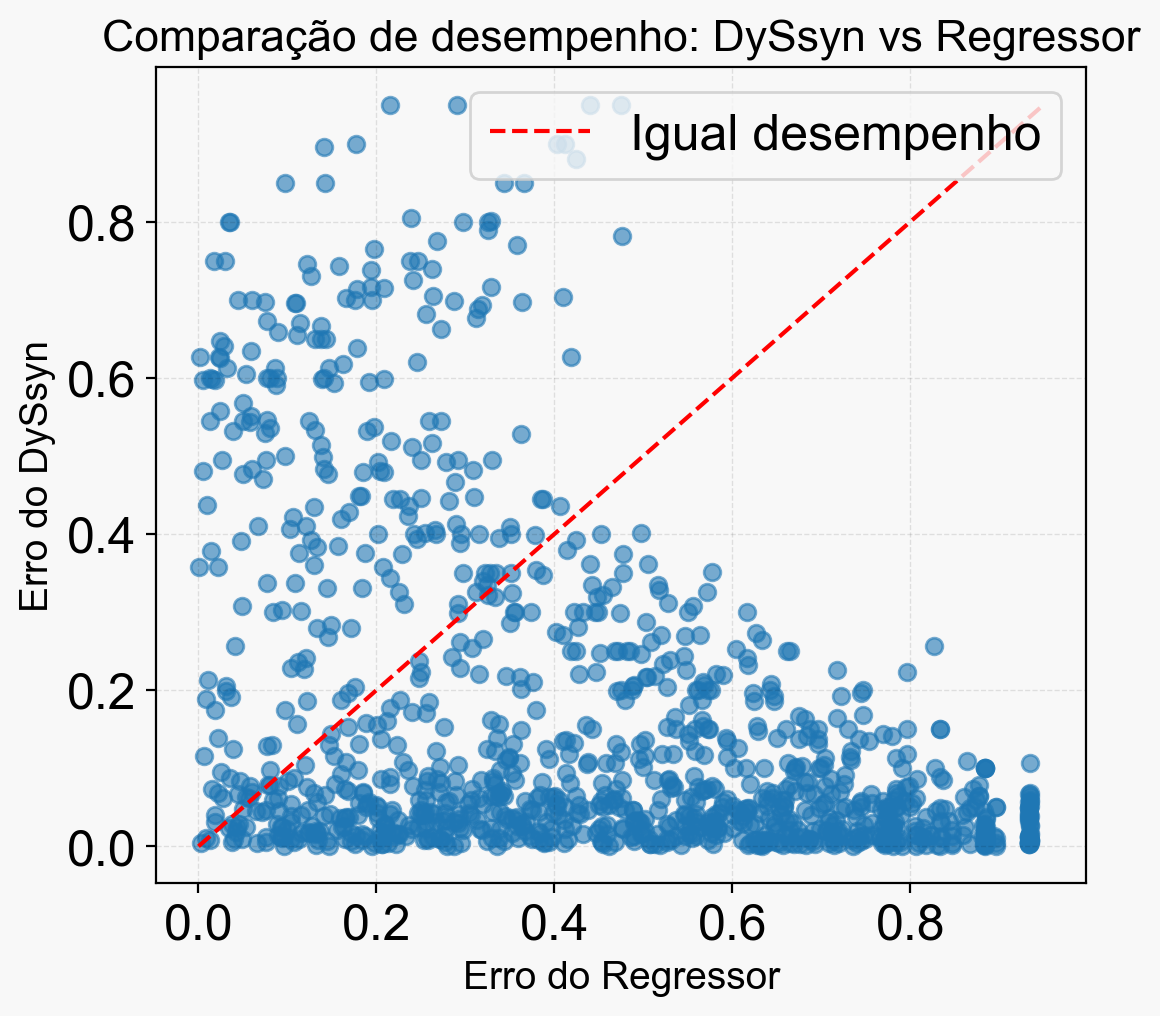

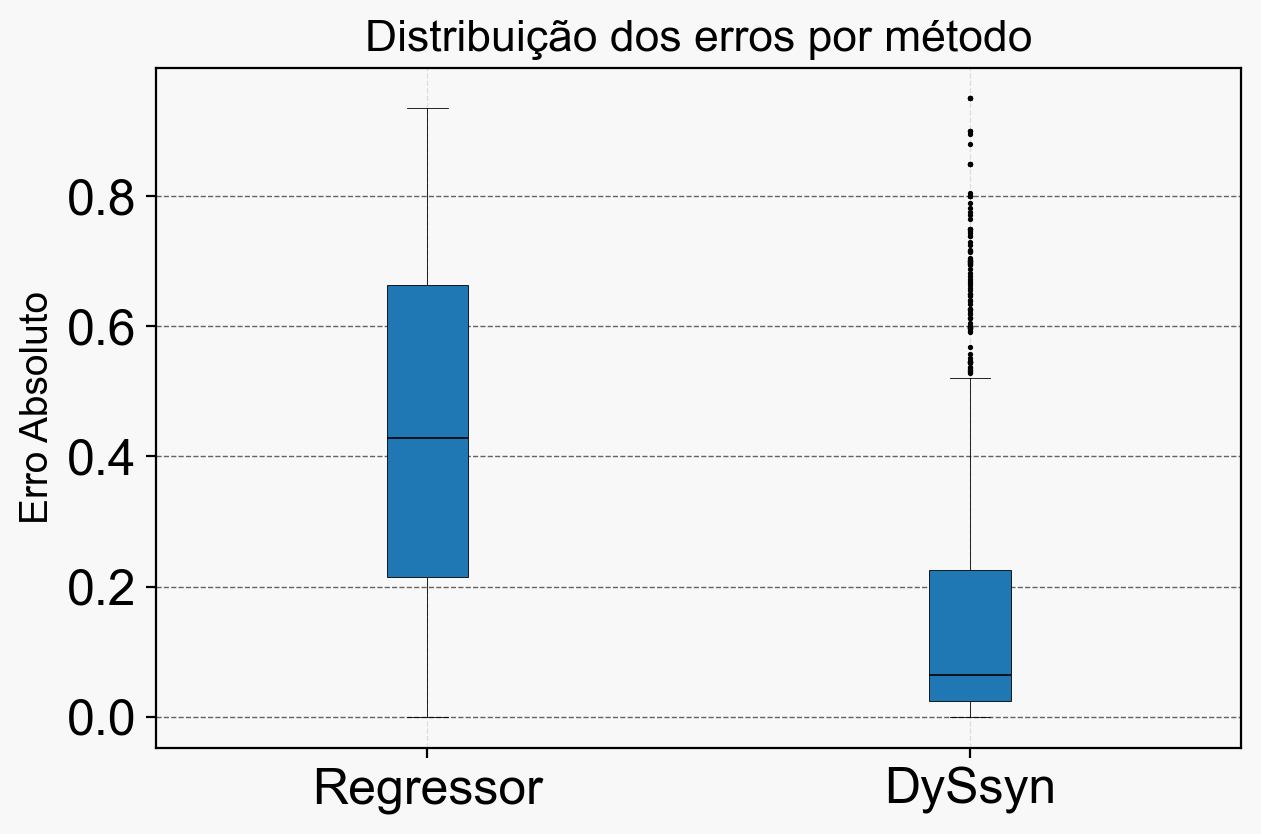

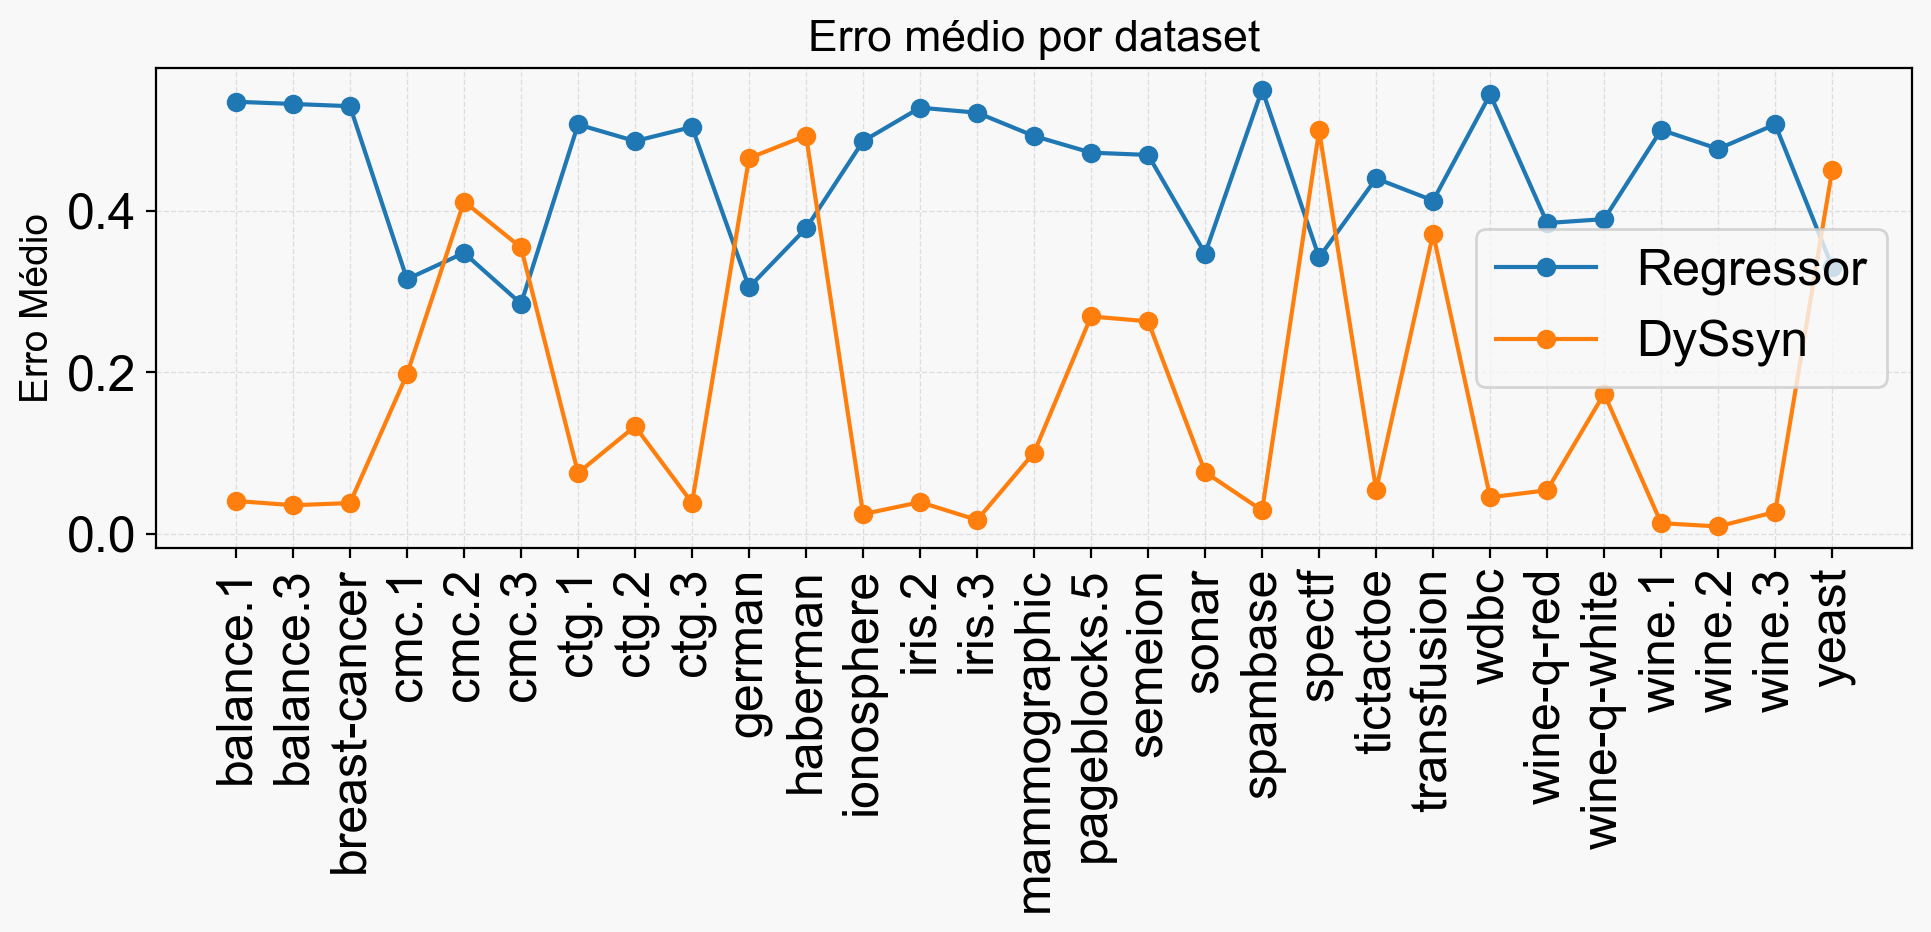

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Lê o CSV gerado anteriormente
resultados_app_detalhado = pd.read_csv("resultados_APP_detalhado.csv")

# --- 1️⃣ Dispersão Regressor vs DySsyn ---
plt.figure(figsize=(6,6))
plt.scatter(
    resultados_app_detalhado['Erro_Regressor'],
    resultados_app_detalhado['Erro_DySsyn'],
    alpha=0.6
)
plt.plot(
    [0, resultados_app_detalhado[['Erro_Regressor','Erro_DySsyn']].values.max()],
    [0, resultados_app_detalhado[['Erro_Regressor','Erro_DySsyn']].values.max()],
    'r--', label='Igual desempenho'
)
plt.xlabel('Erro do Regressor')
plt.ylabel('Erro do DySsyn')
plt.title('Comparação de desempenho: DySsyn vs Regressor')
plt.legend()
plt.grid(True)
plt.show()


# --- 2️⃣ Boxplot comparando distribuições ---
plt.figure(figsize=(7,5))
plt.boxplot(
    [resultados_app_detalhado['Erro_Regressor'], resultados_app_detalhado['Erro_DySsyn']],
    labels=['Regressor', 'DySsyn'],
    patch_artist=True
)
plt.ylabel('Erro Absoluto')
plt.title('Distribuição dos erros por método')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()


# --- 3️⃣ Médias por dataset ---
df_medias = resultados_app_detalhado.groupby("Dataset")[["Erro_Regressor","Erro_DySsyn"]].mean().reset_index()

plt.figure(figsize=(10,5))
plt.plot(df_medias["Dataset"], df_medias["Erro_Regressor"], 'o-', label="Regressor")
plt.plot(df_medias["Dataset"], df_medias["Erro_DySsyn"], 'o-', label="DySsyn")
plt.xticks(rotation=90)
plt.ylabel("Erro Médio")
plt.title("Erro médio por dataset")
plt.legend()
plt.tight_layout()
plt.show()

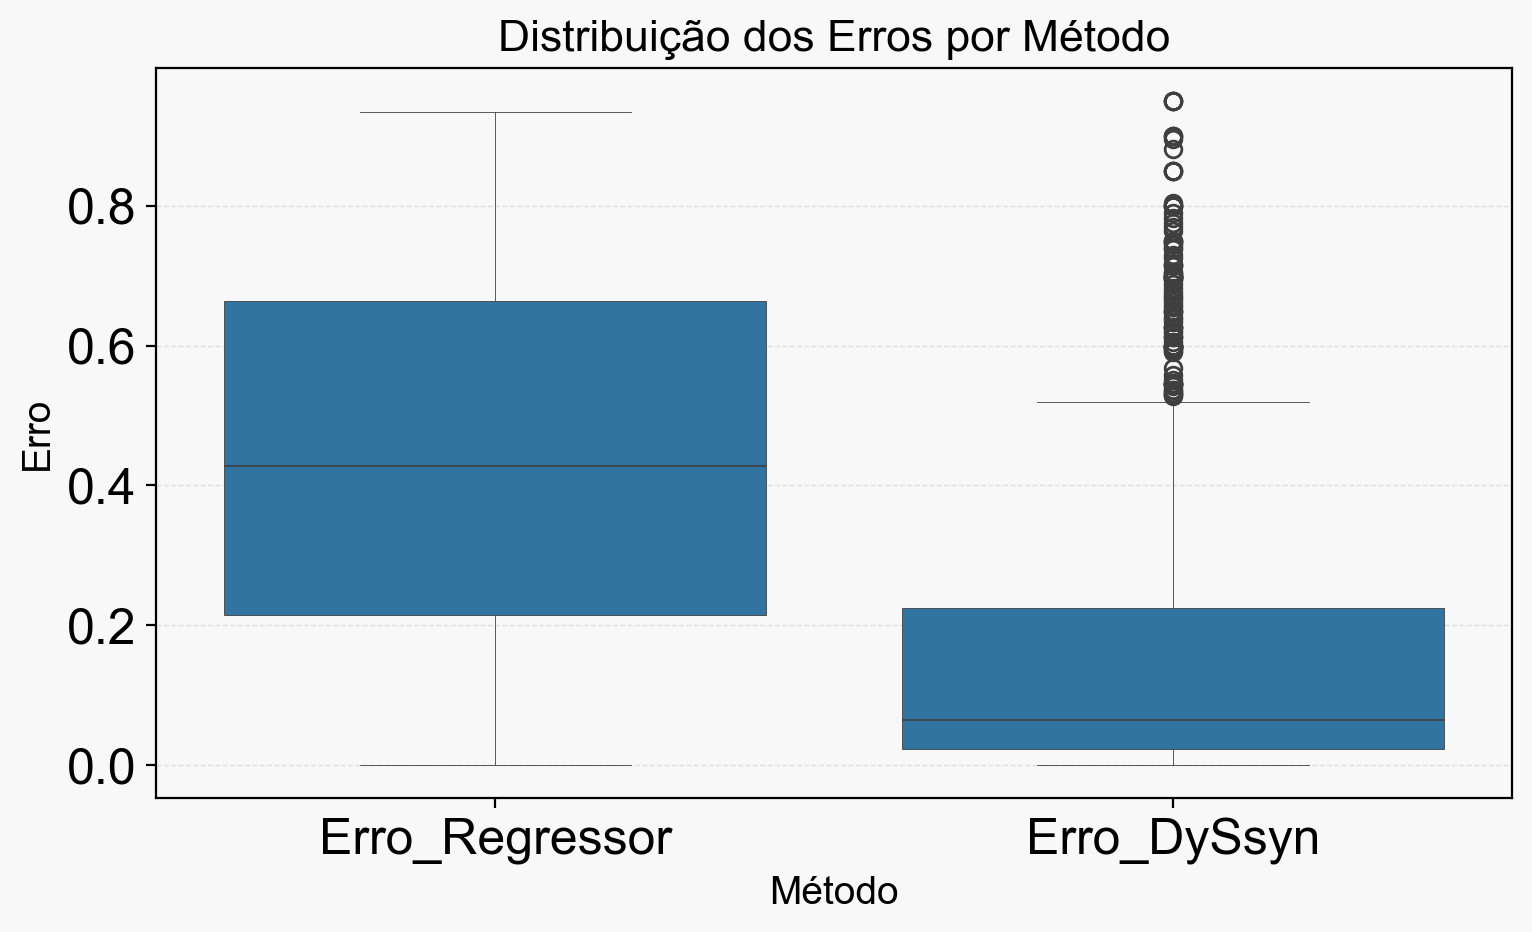

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Carrega o CSV
resultados_app_detalhado = pd.read_csv("resultados_app_detalhado.csv")

# Reorganiza o DataFrame para formato longo
df_long = pd.melt(resultados_app_detalhado,
                  id_vars=['Dataset'],
                  value_vars=['Erro_Regressor', 'Erro_DySsyn'],
                  var_name='Método',
                  value_name='Erro')

plt.figure(figsize=(8,5))
sns.boxplot(data=df_long, x='Método', y='Erro')
plt.title('Distribuição dos Erros por Método')
plt.tight_layout()
plt.show()


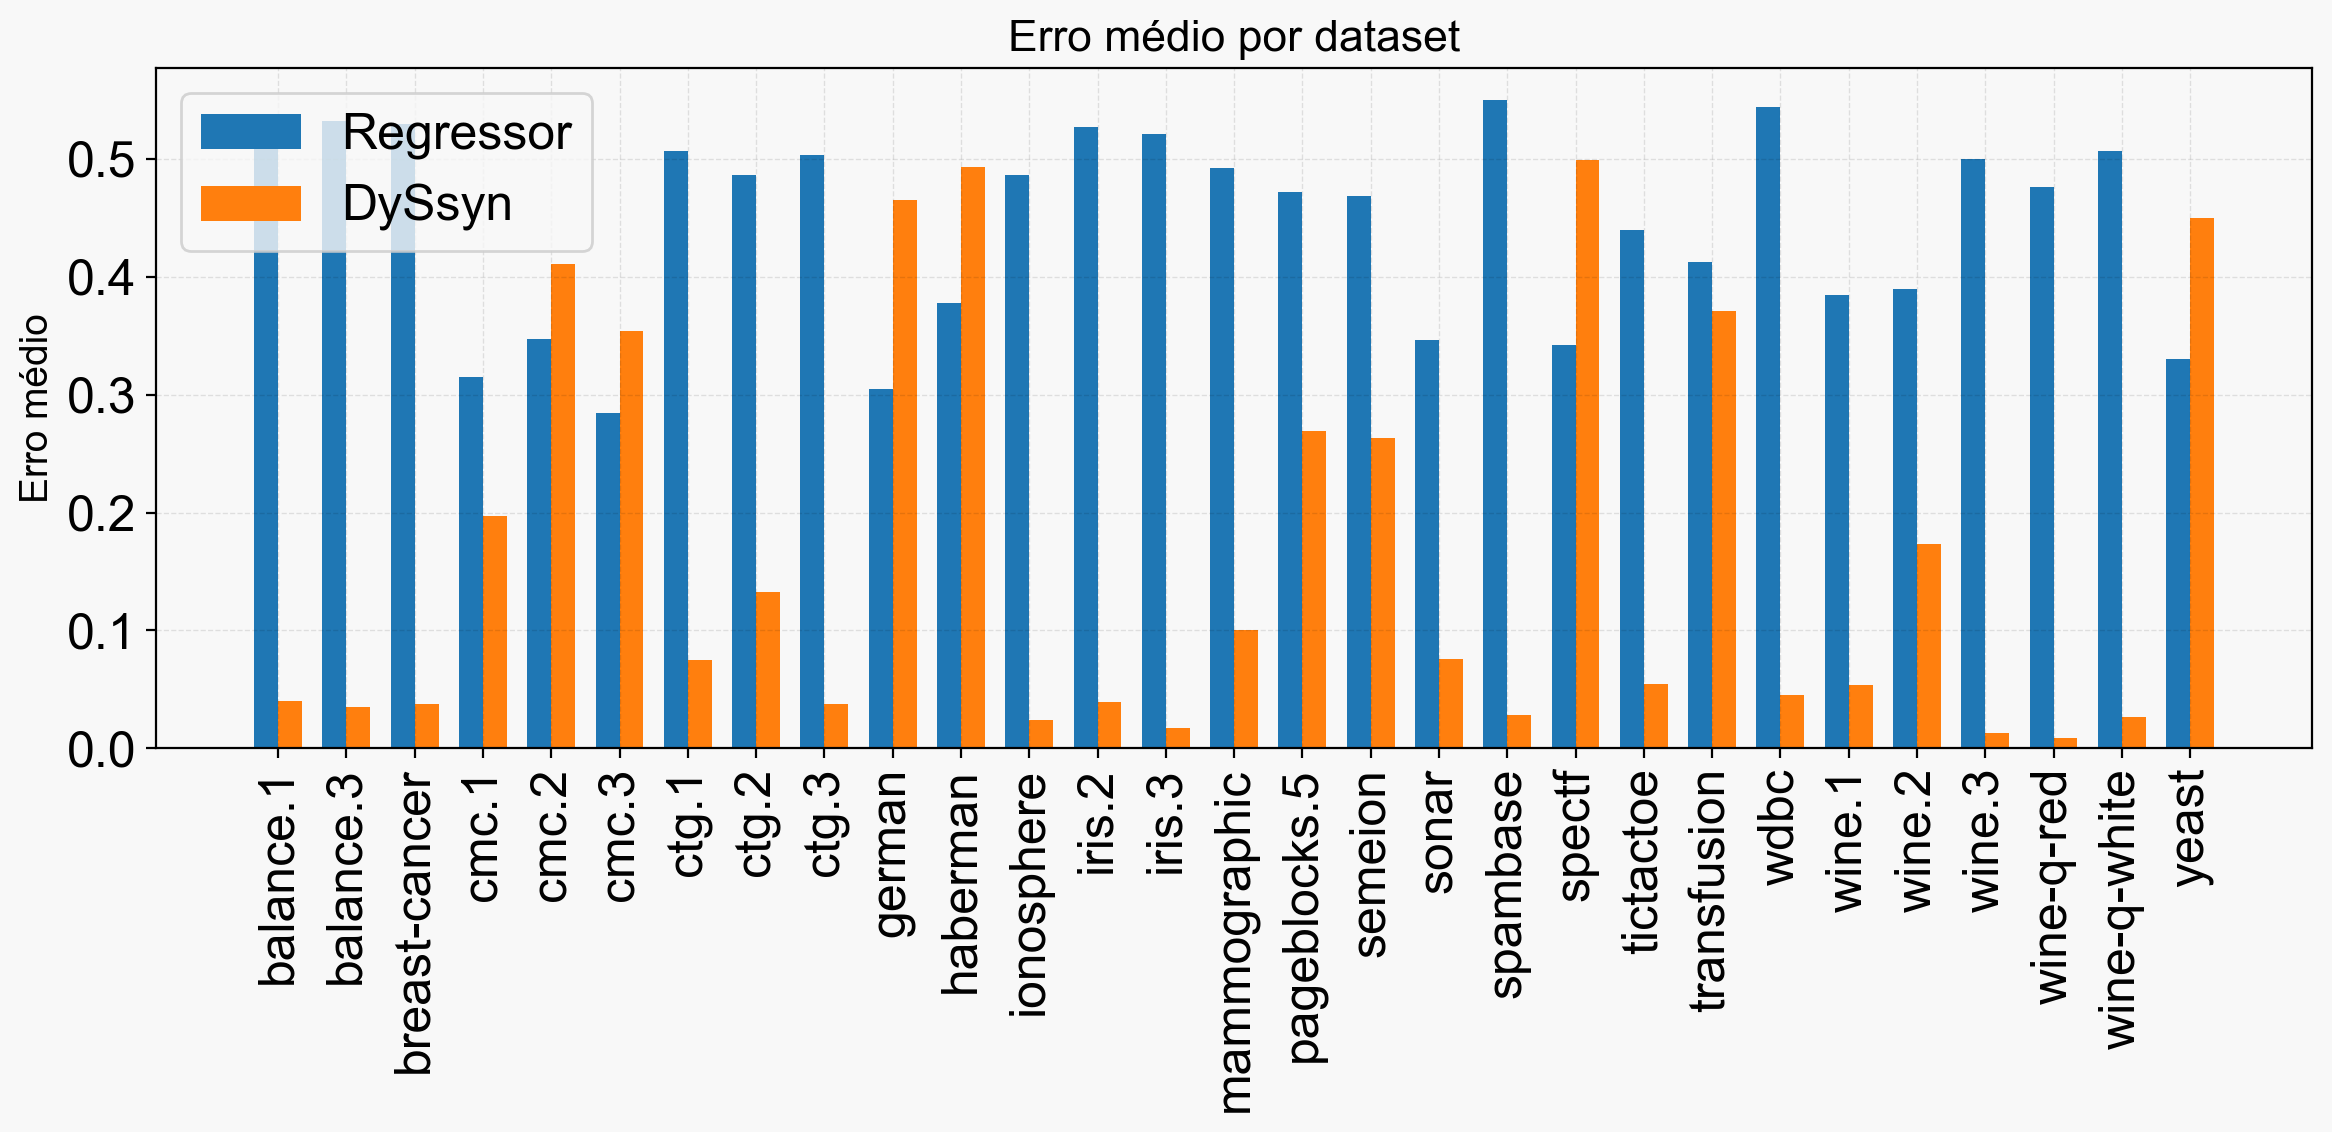

In [31]:
import matplotlib.pyplot as plt
import numpy as np

datasets = resultados_app_detalhado['Dataset'].unique()
x = np.arange(len(datasets))
width = 0.35

erro_reg = resultados_app_detalhado.groupby('Dataset')['Erro_Regressor'].mean()
erro_dys = resultados_app_detalhado.groupby('Dataset')['Erro_DySsyn'].mean()

plt.figure(figsize=(12,6))
plt.bar(x - width/2, erro_reg, width, label='Regressor')
plt.bar(x + width/2, erro_dys, width, label='DySsyn')

plt.xticks(x, datasets, rotation=90)
plt.ylabel('Erro médio')
plt.title('Erro médio por dataset')
plt.legend()
plt.tight_layout()
plt.show()


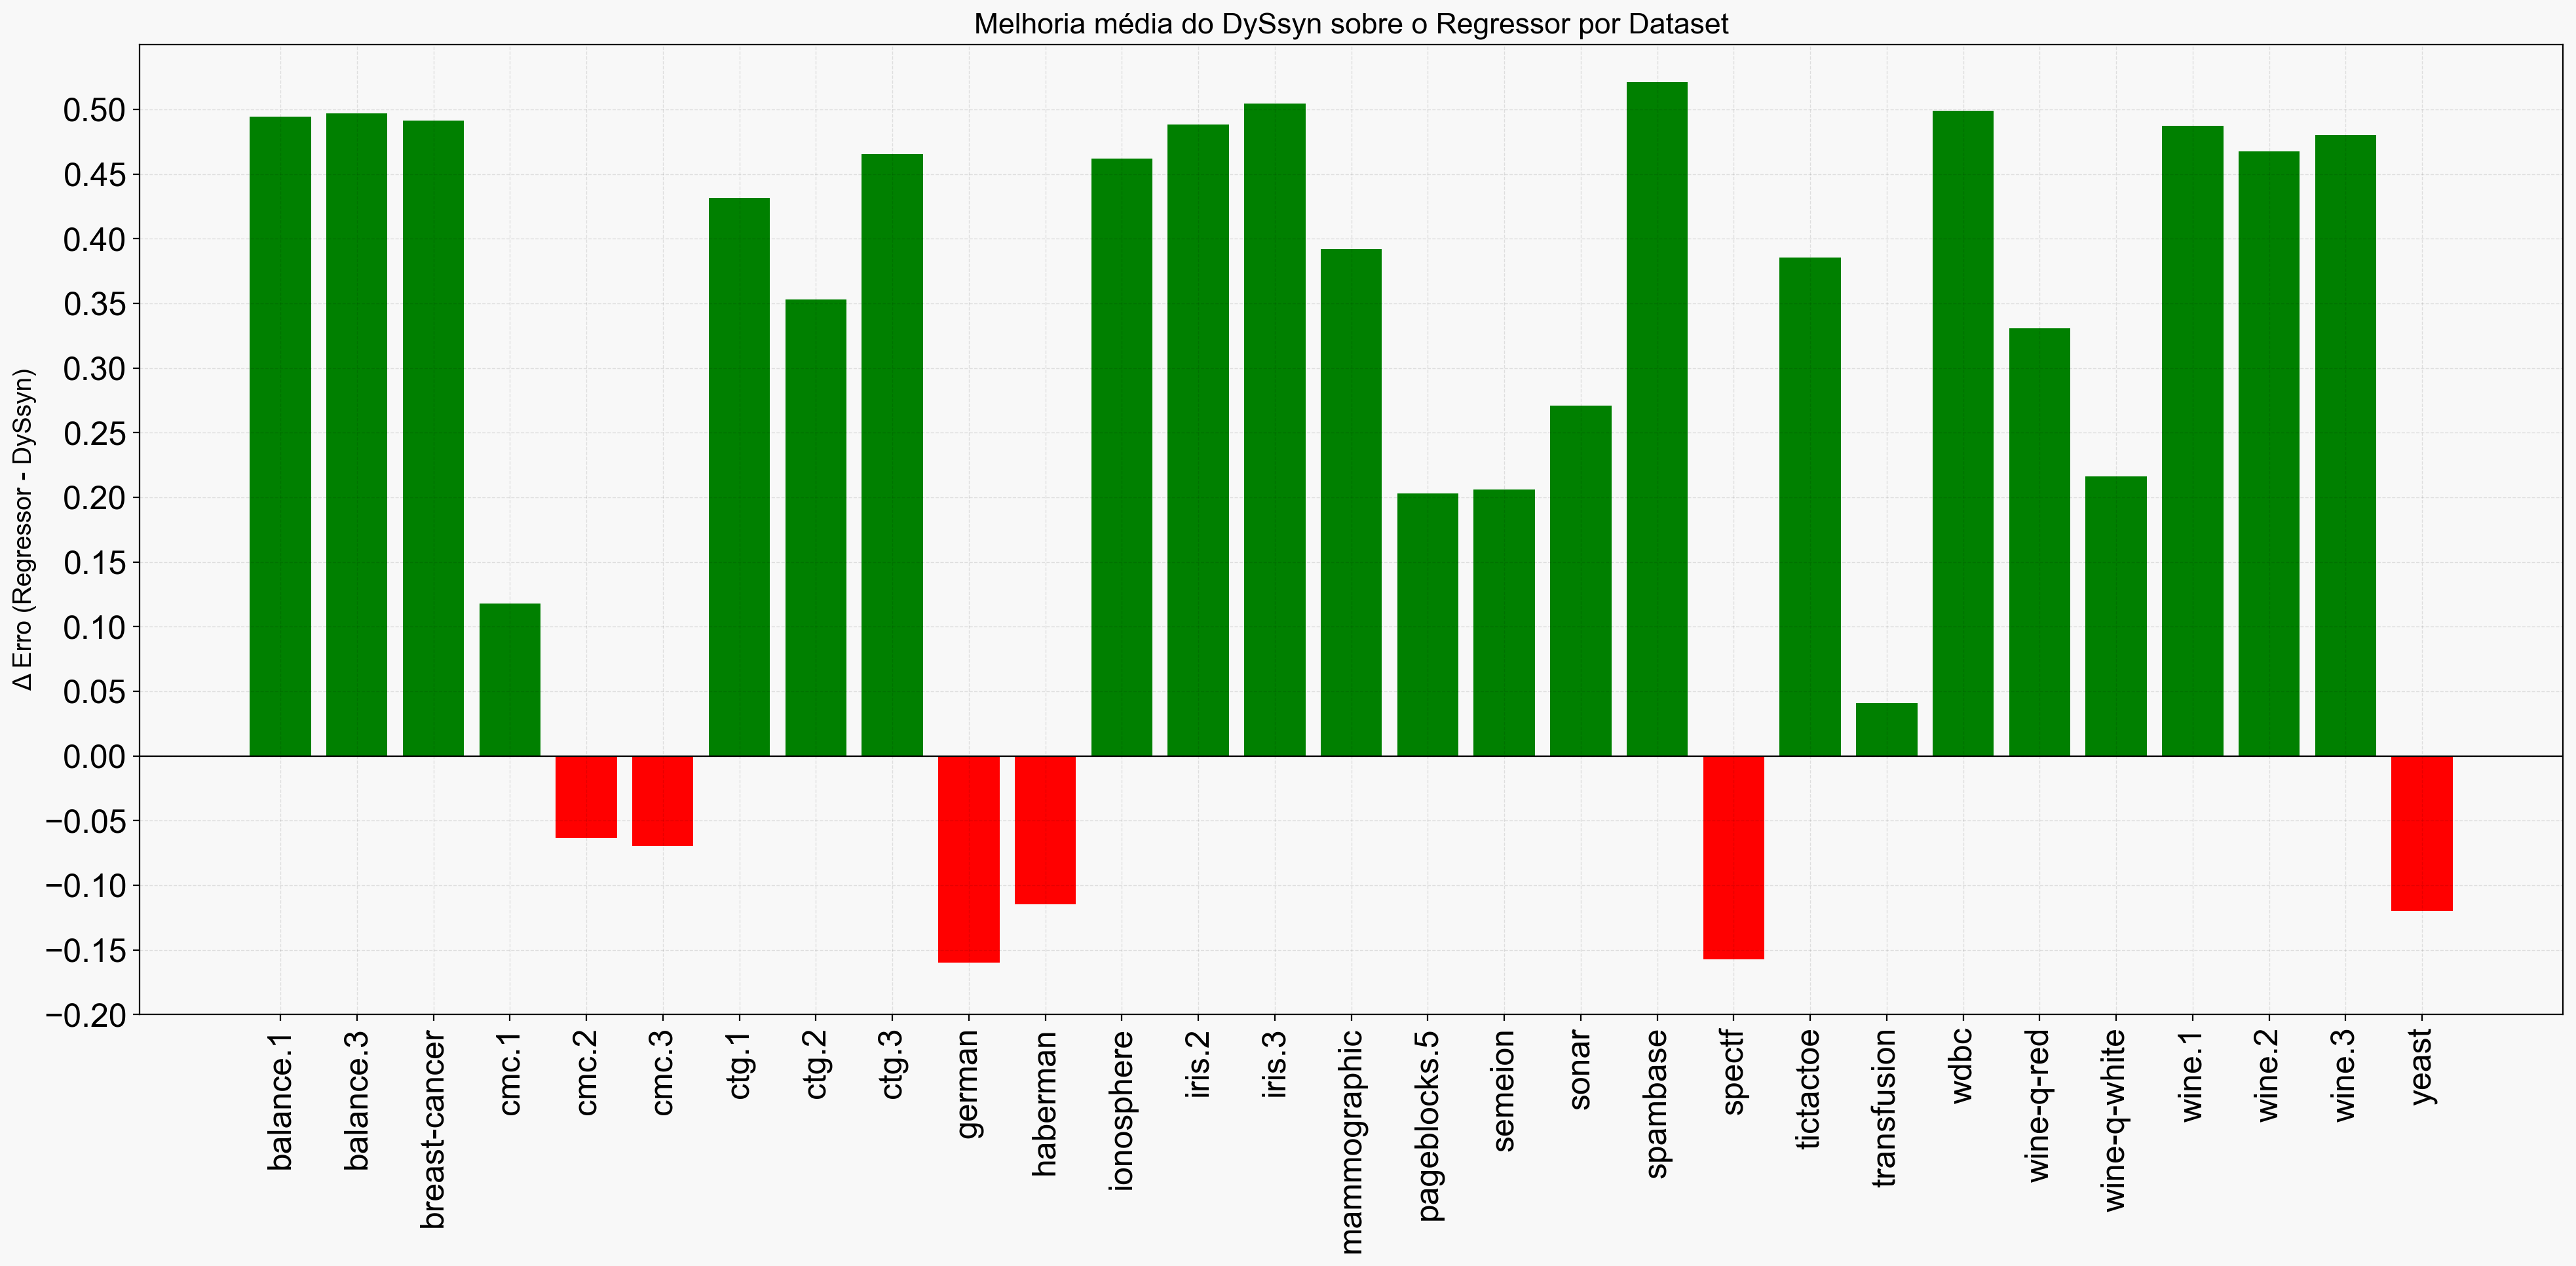

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("resultados_APP_detalhado.csv")

# Calcula a média da diferença por dataset
df_mean = df.groupby("Dataset", as_index=False).agg({
    "Erro_Regressor": "mean",
    "Erro_DySsyn": "mean"
})
df_mean["Diferença"] = df_mean["Erro_Regressor"] - df_mean["Erro_DySsyn"]

plt.figure(figsize=(20,10))
plt.bar(df_mean["Dataset"], df_mean["Diferença"], 
        color=["green" if d > 0 else "red" for d in df_mean["Diferença"]])
plt.xticks(rotation=90)
plt.ylabel("Δ Erro (Regressor - DySsyn)")
plt.title("Melhoria média do DySsyn sobre o Regressor por Dataset")
plt.axhline(0, color="black", linewidth=0.8)

# Define ticks do eixo Y de 0.05 em 0.05
ymin, ymax = plt.ylim()  # pega limites automáticos
plt.yticks(np.arange(-0.5, 0.55, 0.05))
plt.ylim(-0.2, 0.55)

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, entropy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from mlquantify.methods.aggregative import DySsyn
import quapy as qp
import pickle
import warnings
import time
from typing import Protocol

warnings.filterwarnings("ignore")

# ===========================
# ===== Funções base ========
# ===========================

def extract_features(scores):
    features = {
        'mean': np.mean(scores),
        'var': np.var(scores),
        'skew': skew(scores),
        'kurt': kurtosis(scores),
        'q10': np.quantile(scores, 0.1),
        'q25': np.quantile(scores, 0.25),
        'q50': np.quantile(scores, 0.5),
        'q75': np.quantile(scores, 0.75),
        'q90': np.quantile(scores, 0.9)
    }
    hist, _ = np.histogram(scores, bins=20, density=True)
    hist = hist + 1e-12
    features['entropy'] = entropy(hist)
    return features


def generate_artificial_prevalences(n_dim, n_prev=19, n_iter=1):
    if n_dim != 2:
        raise NotImplementedError("Apenas binário por enquanto.")
    prevalences = np.linspace(0.05, 0.95, n_prev)
    combos = [[1-p, p] for p in prevalences]
    return combos * n_iter


def get_indexes_with_prevalence(y, prevalence, batch_size):
    pos_idx = np.where(y == 1)[0]
    neg_idx = np.where(y == 0)[0]
    n_pos = int(batch_size * prevalence[1])
    n_neg = batch_size - n_pos
    pos_sel = np.random.choice(pos_idx, size=n_pos, replace=True)
    neg_sel = np.random.choice(neg_idx, size=n_neg, replace=True)
    idx = np.concatenate([pos_sel, neg_sel])
    np.random.shuffle(idx)
    return idx


class APP(Protocol):
    def __init__(self, batch_size, n_prevalences, repeats=1, random_state=None):
        self.batch_size = batch_size if isinstance(batch_size, list) else [batch_size]
        self.n_prevalences = n_prevalences
        self.repeats = repeats
        self.random_state = random_state
        if random_state is not None:
            np.random.seed(random_state)

    def split(self, X, y):
        n_dim = len(np.unique(y))
        for batch_size in self.batch_size:
            prevalences = generate_artificial_prevalences(n_dim, self.n_prevalences, self.repeats)
            for prev in prevalences:
                idx = get_indexes_with_prevalence(y, prev, batch_size)
                yield idx, prev


# ===========================
# ===== Treino Regressor ====
# ===========================

with open("synthetic_distributions.pkl", "rb") as f:
    synthetic_distributions = pickle.load(f)

X_features, y_labels = [], []
for key, curves in synthetic_distributions.items():
    all_scores = np.concatenate(curves) if isinstance(curves, list) else curves
    feats = extract_features(all_scores)
    X_features.append(list(feats.values()))

    if isinstance(key, tuple):
        y_labels.append(key[0])  # alpha
    else:
        y_labels.append(key)

X_features = np.array(X_features)
y_labels = np.array(y_labels)

reg = RandomForestRegressor(n_estimators=300, random_state=42)
reg.fit(X_features, y_labels)


# ===========================
# ===== Avaliação APP =======
# ===========================

def avaliar_dataset_APP(nome, X, y, app_protocol):
    if len(np.unique(y)) > 2:
        y = (y == np.max(y)).astype(int)

    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.5, random_state=42, stratify=y
    )

    clf = RandomForestClassifier(n_estimators=300, random_state=42)
    clf.fit(X_train, y_train)

    dyssin_model = DySsyn(RandomForestClassifier(n_estimators=300, random_state=42))
    dyssin_model.fit(X_train, y_train)

    resultados = []
    tempos_regressor = []
    tempos_dyssyn = []

    for idx, prev in app_protocol.split(X_test, y_test):
        X_batch, y_batch = X_test[idx], y_test[idx]
        real_prev = np.mean(y_batch)
        scores = clf.predict_proba(X_batch)[:, 1]

        # === Tempo Regressor ===
        feats = np.array(list(extract_features(scores).values())).reshape(1, -1)
        t0 = time.perf_counter()
        pred_prev_reg = reg.predict(feats)[0]
        t_reg = time.perf_counter() - t0

        # === Tempo DySsyn ===
        t0 = time.perf_counter()
        pred_prev_dyssin = dyssin_model.predict(X_batch)[1]
        t_dys = time.perf_counter() - t0

        tempos_regressor.append(t_reg)
        tempos_dyssyn.append(t_dys)

        resultados.append({
            "Dataset": nome,
            "Prev_Real": real_prev,
            "Prev_Alvo": prev[1],
            "Regressor": pred_prev_reg,
            "DySsyn": pred_prev_dyssin,
            "Erro_Regressor": abs(real_prev - pred_prev_reg),
            "Erro_DySsyn": abs(real_prev - pred_prev_dyssin),
            "Tempo_Regressor": t_reg,
            "Tempo_DySsyn": t_dys
        })

    df = pd.DataFrame(resultados)
    df["Tempo_Médio_Regressor"] = np.mean(tempos_regressor)
    df["Tempo_Médio_DySsyn"] = np.mean(tempos_dyssyn)
    return df


# ===========================
# ===== Rodar Experimentos ===
# ===========================

datasets_names = [
    "balance.1", "balance.3", "breast-cancer",
    "cmc.1", "cmc.2", "cmc.3", "ctg.1", "ctg.2", "ctg.3", "german",
    "haberman", "ionosphere", "iris.2", "iris.3", "mammographic",
    "pageblocks.5", "semeion", "sonar", "spambase", "spectf",
    "tictactoe", "transfusion", "wdbc", "wine.1", "wine.2",
    "wine.3", "wine-q-red", "wine-q-white", "yeast"
]

app = APP(batch_size=200, n_prevalences=19, repeats=2, random_state=42)

resultados_detalhados = []
resumo_final = []

for nome in datasets_names:
    try:
        print(f"\n🔍 Carregando dataset QuaPy: {nome}")
        dataset = qp.datasets.fetch_UCIBinaryDataset(nome)

        X_train, y_train = dataset.training.X, dataset.training.y
        X_test, y_test = dataset.test.X, dataset.test.y

        X = np.vstack([X_train, X_test])
        y = np.concatenate([y_train, y_test])
        X = np.array(X)
        y = np.array(y).ravel()

        print(f"✅ Rodando APP no dataset {nome}")
        df_app = avaliar_dataset_APP(nome, X, y, app)

        resultados_detalhados.append(df_app)

        mean_errors = df_app[["Erro_Regressor", "Erro_DySsyn"]].mean()
        mean_times = df_app[["Tempo_Regressor", "Tempo_DySsyn"]].mean()

        resumo_final.append({
            "Dataset": nome,
            "Erro Médio Regressor": mean_errors["Erro_Regressor"],
            "Erro Médio DySsyn": mean_errors["Erro_DySsyn"],
            "Tempo Médio Regressor (s)": mean_times["Tempo_Regressor"],
            "Tempo Médio DySsyn (s)": mean_times["Tempo_DySsyn"]
        })

    except Exception as e:
        print(f"❌ Erro no dataset {nome}: {e}")

# ---- Salvar ----
df_detalhado = pd.concat(resultados_detalhados, ignore_index=True)
df_resumo = pd.DataFrame(resumo_final)

df_detalhado.to_csv("resultados_APP_detalhado.csv", index=False)
df_resumo.to_csv("resultados_APP_resumo.csv", index=False)

print("\n===== RESULTADOS SALVOS =====")
print("📄 resultados_APP_detalhado.csv → 1 linha por prevalência")
print("📄 resultados_APP_resumo.csv → 1 linha por dataset (média dos erros e tempos)")


🔍 Carregando dataset QuaPy: balance.1
✅ Rodando APP no dataset balance.1

🔍 Carregando dataset QuaPy: balance.3
✅ Rodando APP no dataset balance.3

🔍 Carregando dataset QuaPy: breast-cancer
✅ Rodando APP no dataset breast-cancer

🔍 Carregando dataset QuaPy: cmc.1
✅ Rodando APP no dataset cmc.1

🔍 Carregando dataset QuaPy: cmc.2
✅ Rodando APP no dataset cmc.2

🔍 Carregando dataset QuaPy: cmc.3
✅ Rodando APP no dataset cmc.3

🔍 Carregando dataset QuaPy: ctg.1
✅ Rodando APP no dataset ctg.1

🔍 Carregando dataset QuaPy: ctg.2
✅ Rodando APP no dataset ctg.2

🔍 Carregando dataset QuaPy: ctg.3
✅ Rodando APP no dataset ctg.3

🔍 Carregando dataset QuaPy: german
✅ Rodando APP no dataset german

🔍 Carregando dataset QuaPy: haberman
✅ Rodando APP no dataset haberman

🔍 Carregando dataset QuaPy: ionosphere
✅ Rodando APP no dataset ionosphere

🔍 Carregando dataset QuaPy: iris.2
✅ Rodando APP no dataset iris.2

🔍 Carregando dataset QuaPy: iris.3
✅ Rodando APP no dataset iris.3

🔍 Carregando dataset 

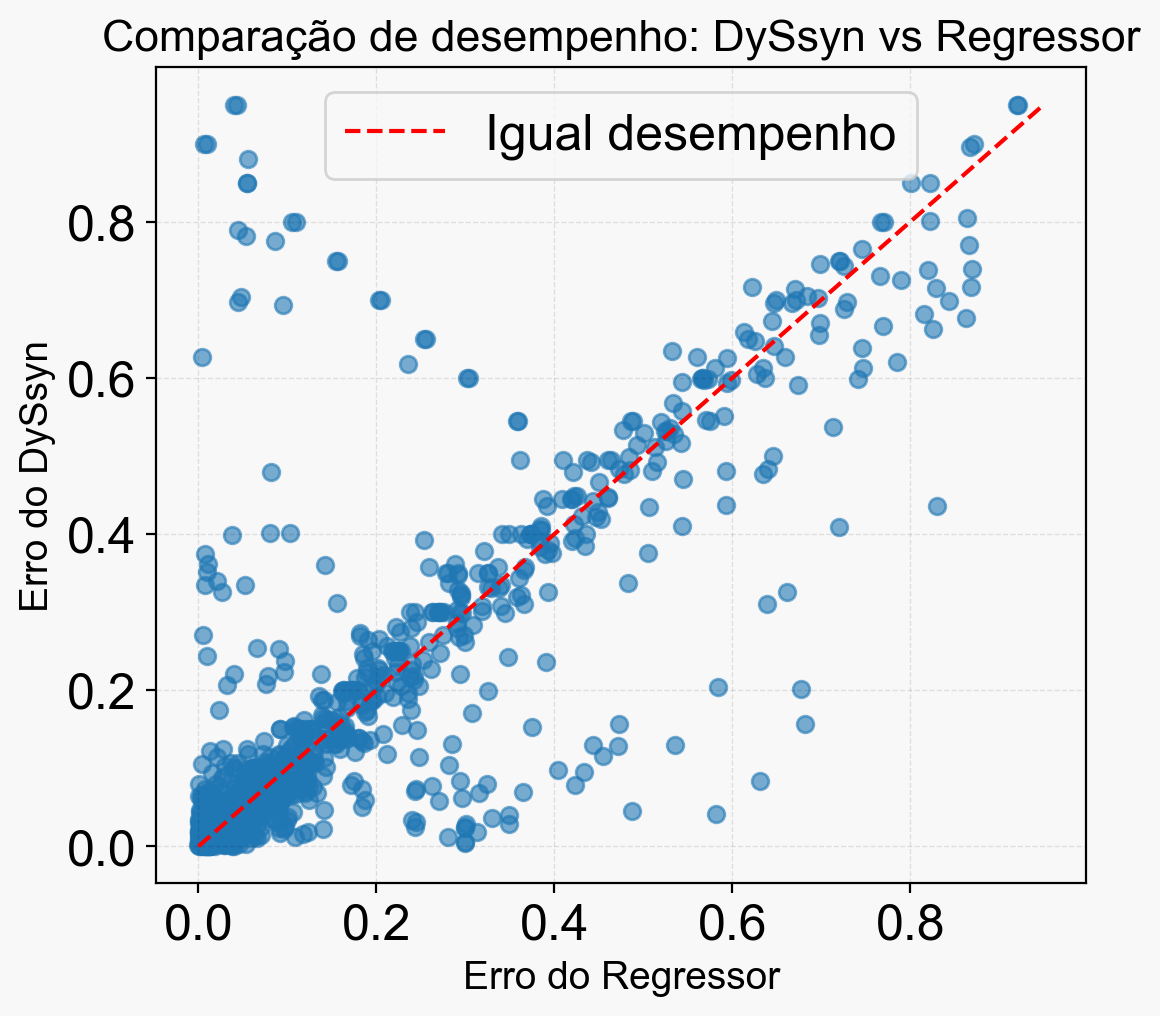

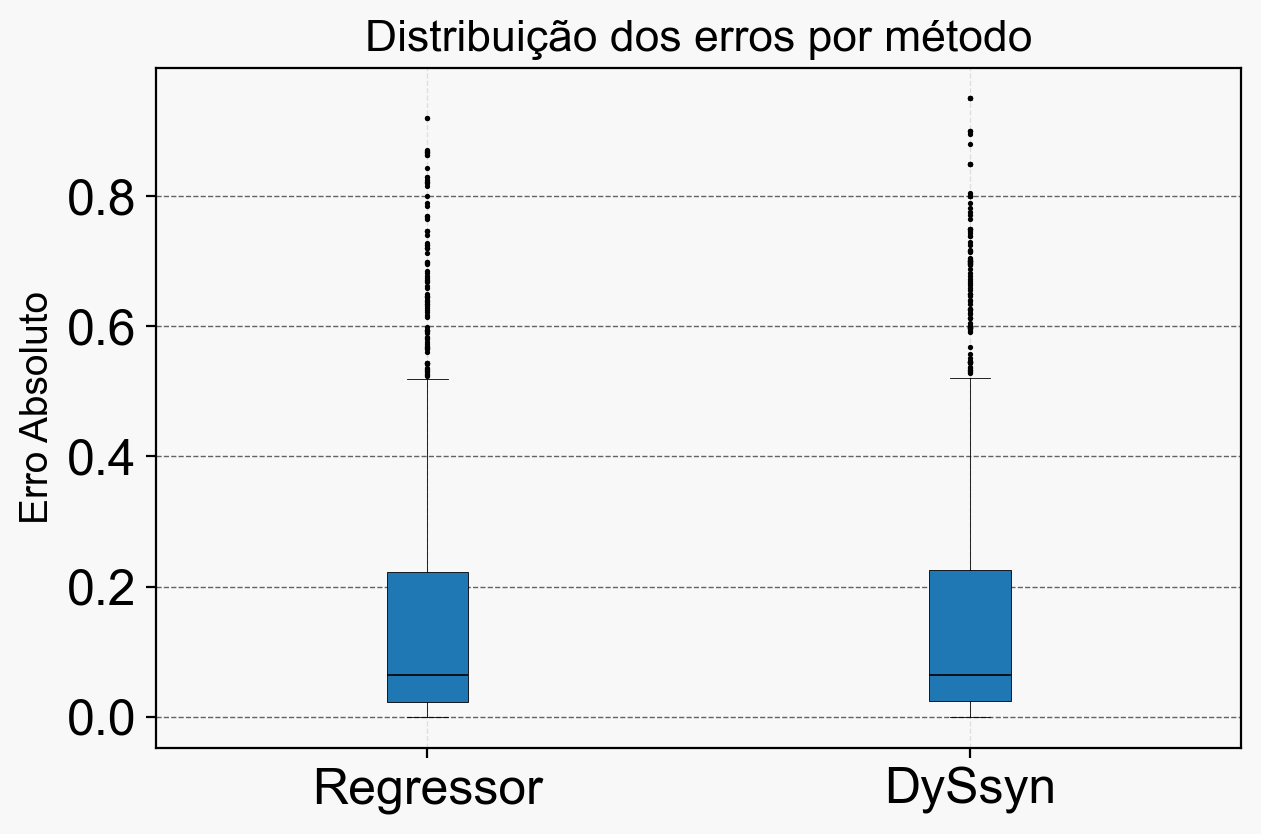

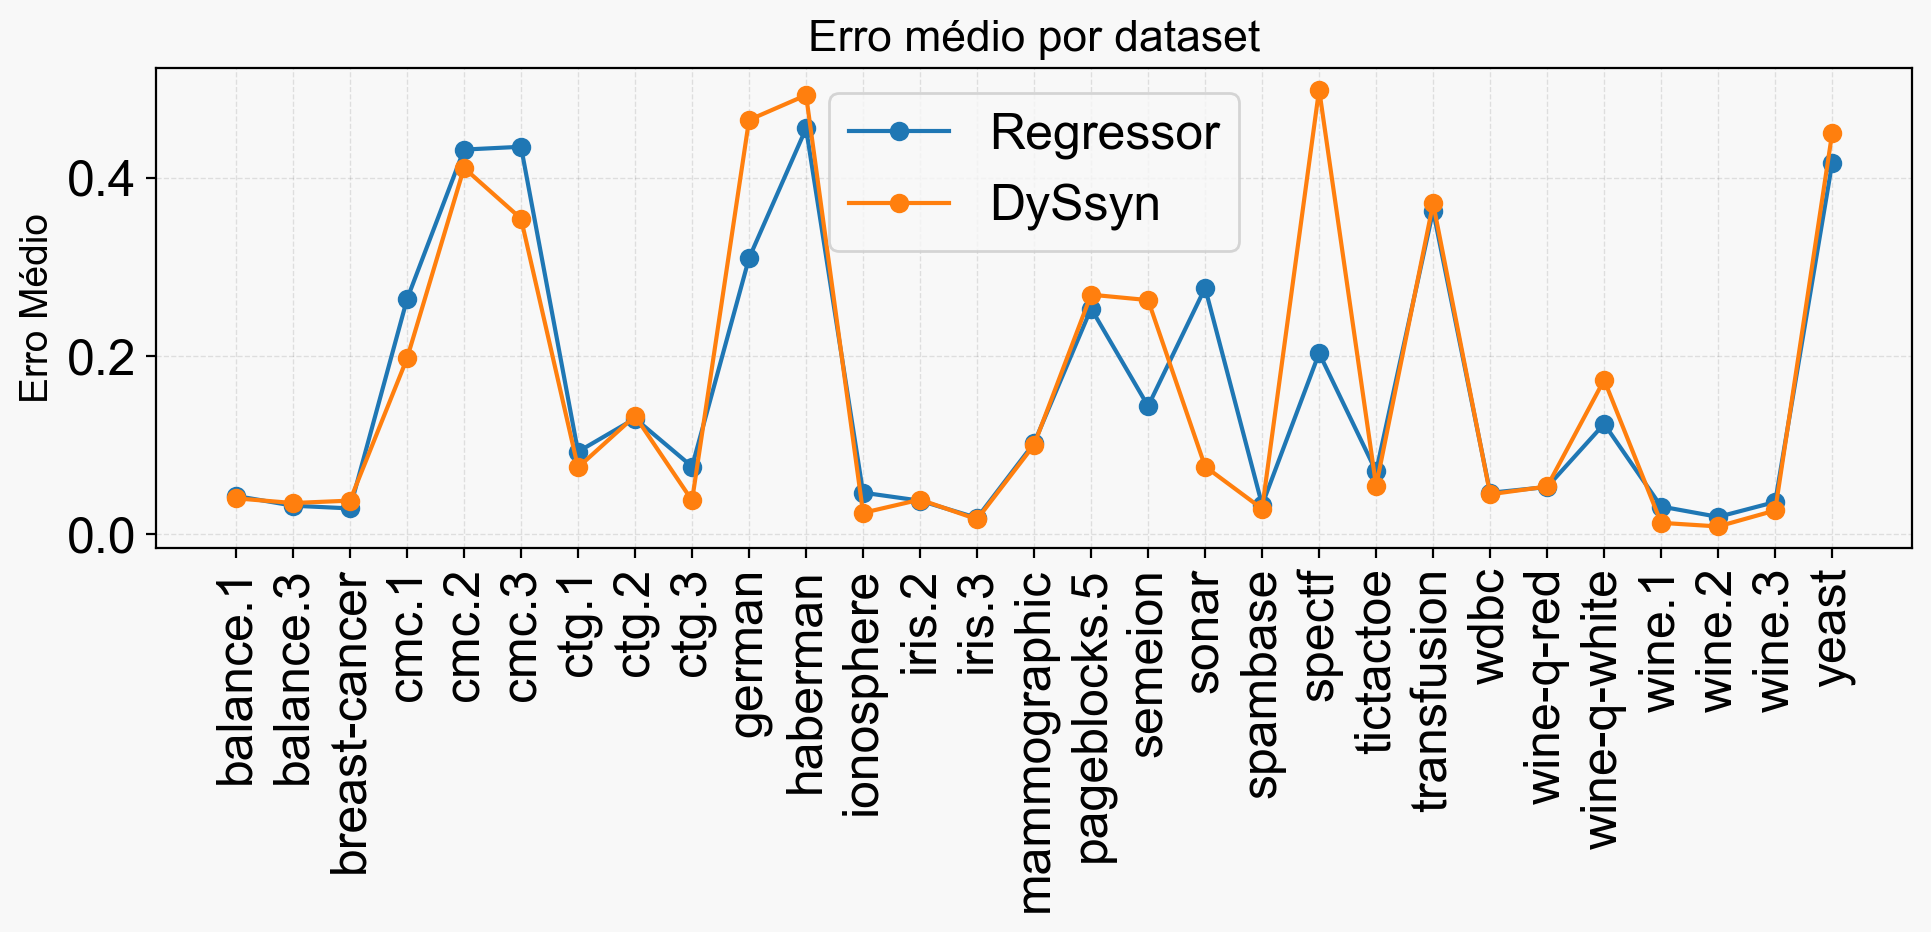

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Lê o CSV gerado anteriormente
resultados_app_detalhado = pd.read_csv("resultados_APP_detalhado.csv")

# --- 1️⃣ Dispersão Regressor vs DySsyn ---
plt.figure(figsize=(6,6))
plt.scatter(
    resultados_app_detalhado['Erro_Regressor'],
    resultados_app_detalhado['Erro_DySsyn'],
    alpha=0.6
)
plt.plot(
    [0, resultados_app_detalhado[['Erro_Regressor','Erro_DySsyn']].values.max()],
    [0, resultados_app_detalhado[['Erro_Regressor','Erro_DySsyn']].values.max()],
    'r--', label='Igual desempenho'
)
plt.xlabel('Erro do Regressor')
plt.ylabel('Erro do DySsyn')
plt.title('Comparação de desempenho: DySsyn vs Regressor')
plt.legend()
plt.grid(True)
plt.show()


# --- 2️⃣ Boxplot comparando distribuições ---
plt.figure(figsize=(7,5))
plt.boxplot(
    [resultados_app_detalhado['Erro_Regressor'], resultados_app_detalhado['Erro_DySsyn']],
    labels=['Regressor', 'DySsyn'],
    patch_artist=True
)
plt.ylabel('Erro Absoluto')
plt.title('Distribuição dos erros por método')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()


# --- 3️⃣ Médias por dataset ---
df_medias = resultados_app_detalhado.groupby("Dataset")[["Erro_Regressor","Erro_DySsyn"]].mean().reset_index()

plt.figure(figsize=(10,5))
plt.plot(df_medias["Dataset"], df_medias["Erro_Regressor"], 'o-', label="Regressor")
plt.plot(df_medias["Dataset"], df_medias["Erro_DySsyn"], 'o-', label="DySsyn")
plt.xticks(rotation=90)
plt.ylabel("Erro Médio")
plt.title("Erro médio por dataset")
plt.legend()
plt.tight_layout()
plt.show()

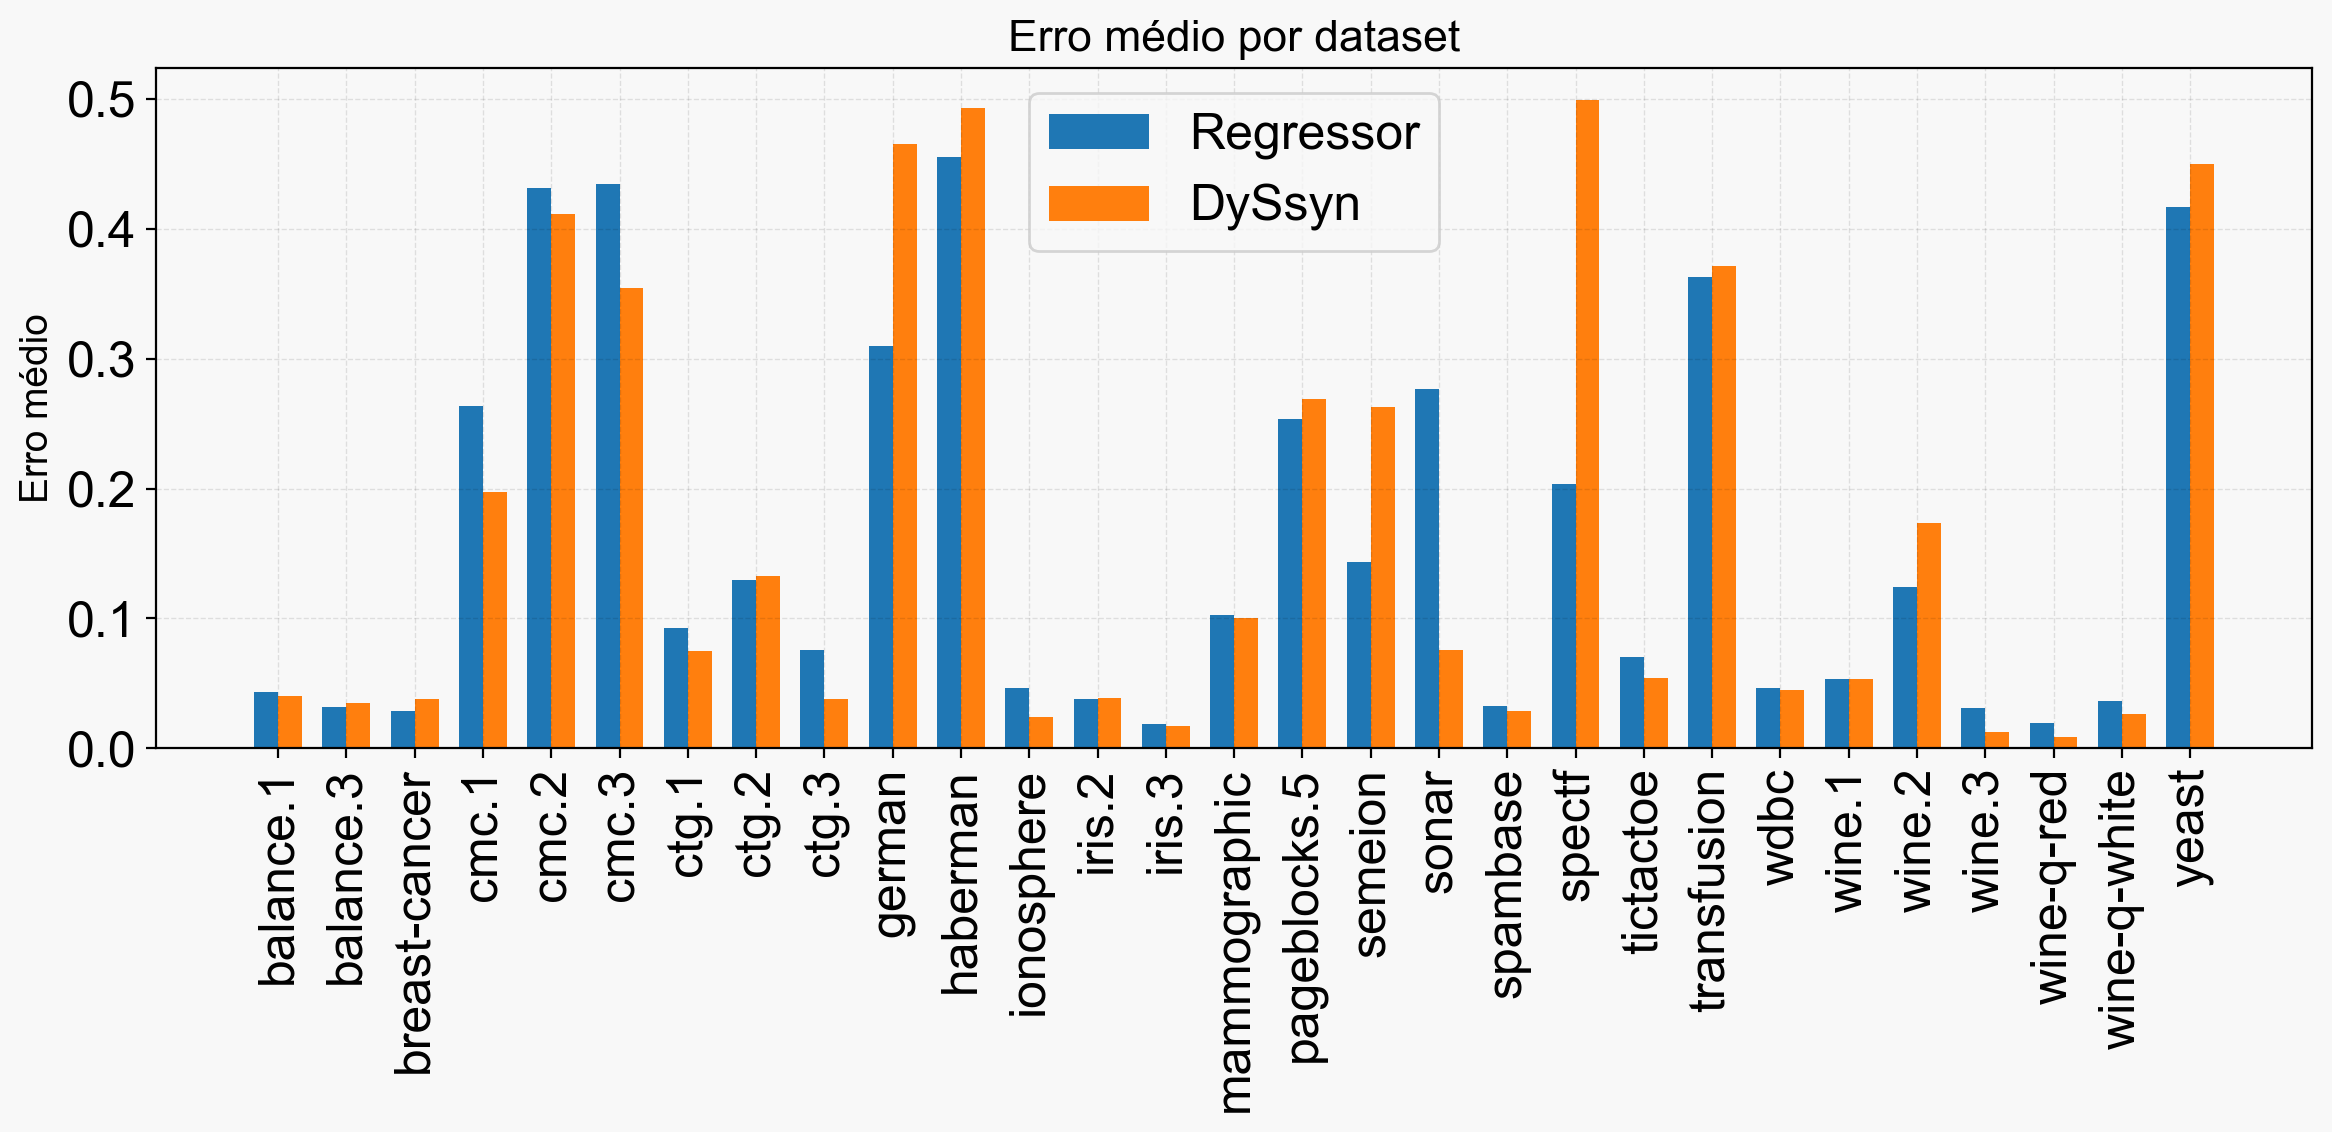

In [17]:
import matplotlib.pyplot as plt
import numpy as np

datasets = resultados_app_detalhado['Dataset'].unique()
x = np.arange(len(datasets))
width = 0.35

erro_reg = resultados_app_detalhado.groupby('Dataset')['Erro_Regressor'].mean()
erro_dys = resultados_app_detalhado.groupby('Dataset')['Erro_DySsyn'].mean()

plt.figure(figsize=(12,6))
plt.bar(x - width/2, erro_reg, width, label='Regressor')
plt.bar(x + width/2, erro_dys, width, label='DySsyn')

plt.xticks(x, datasets, rotation=90)
plt.ylabel('Erro médio')
plt.title('Erro médio por dataset')
plt.legend()
plt.tight_layout()
plt.show()

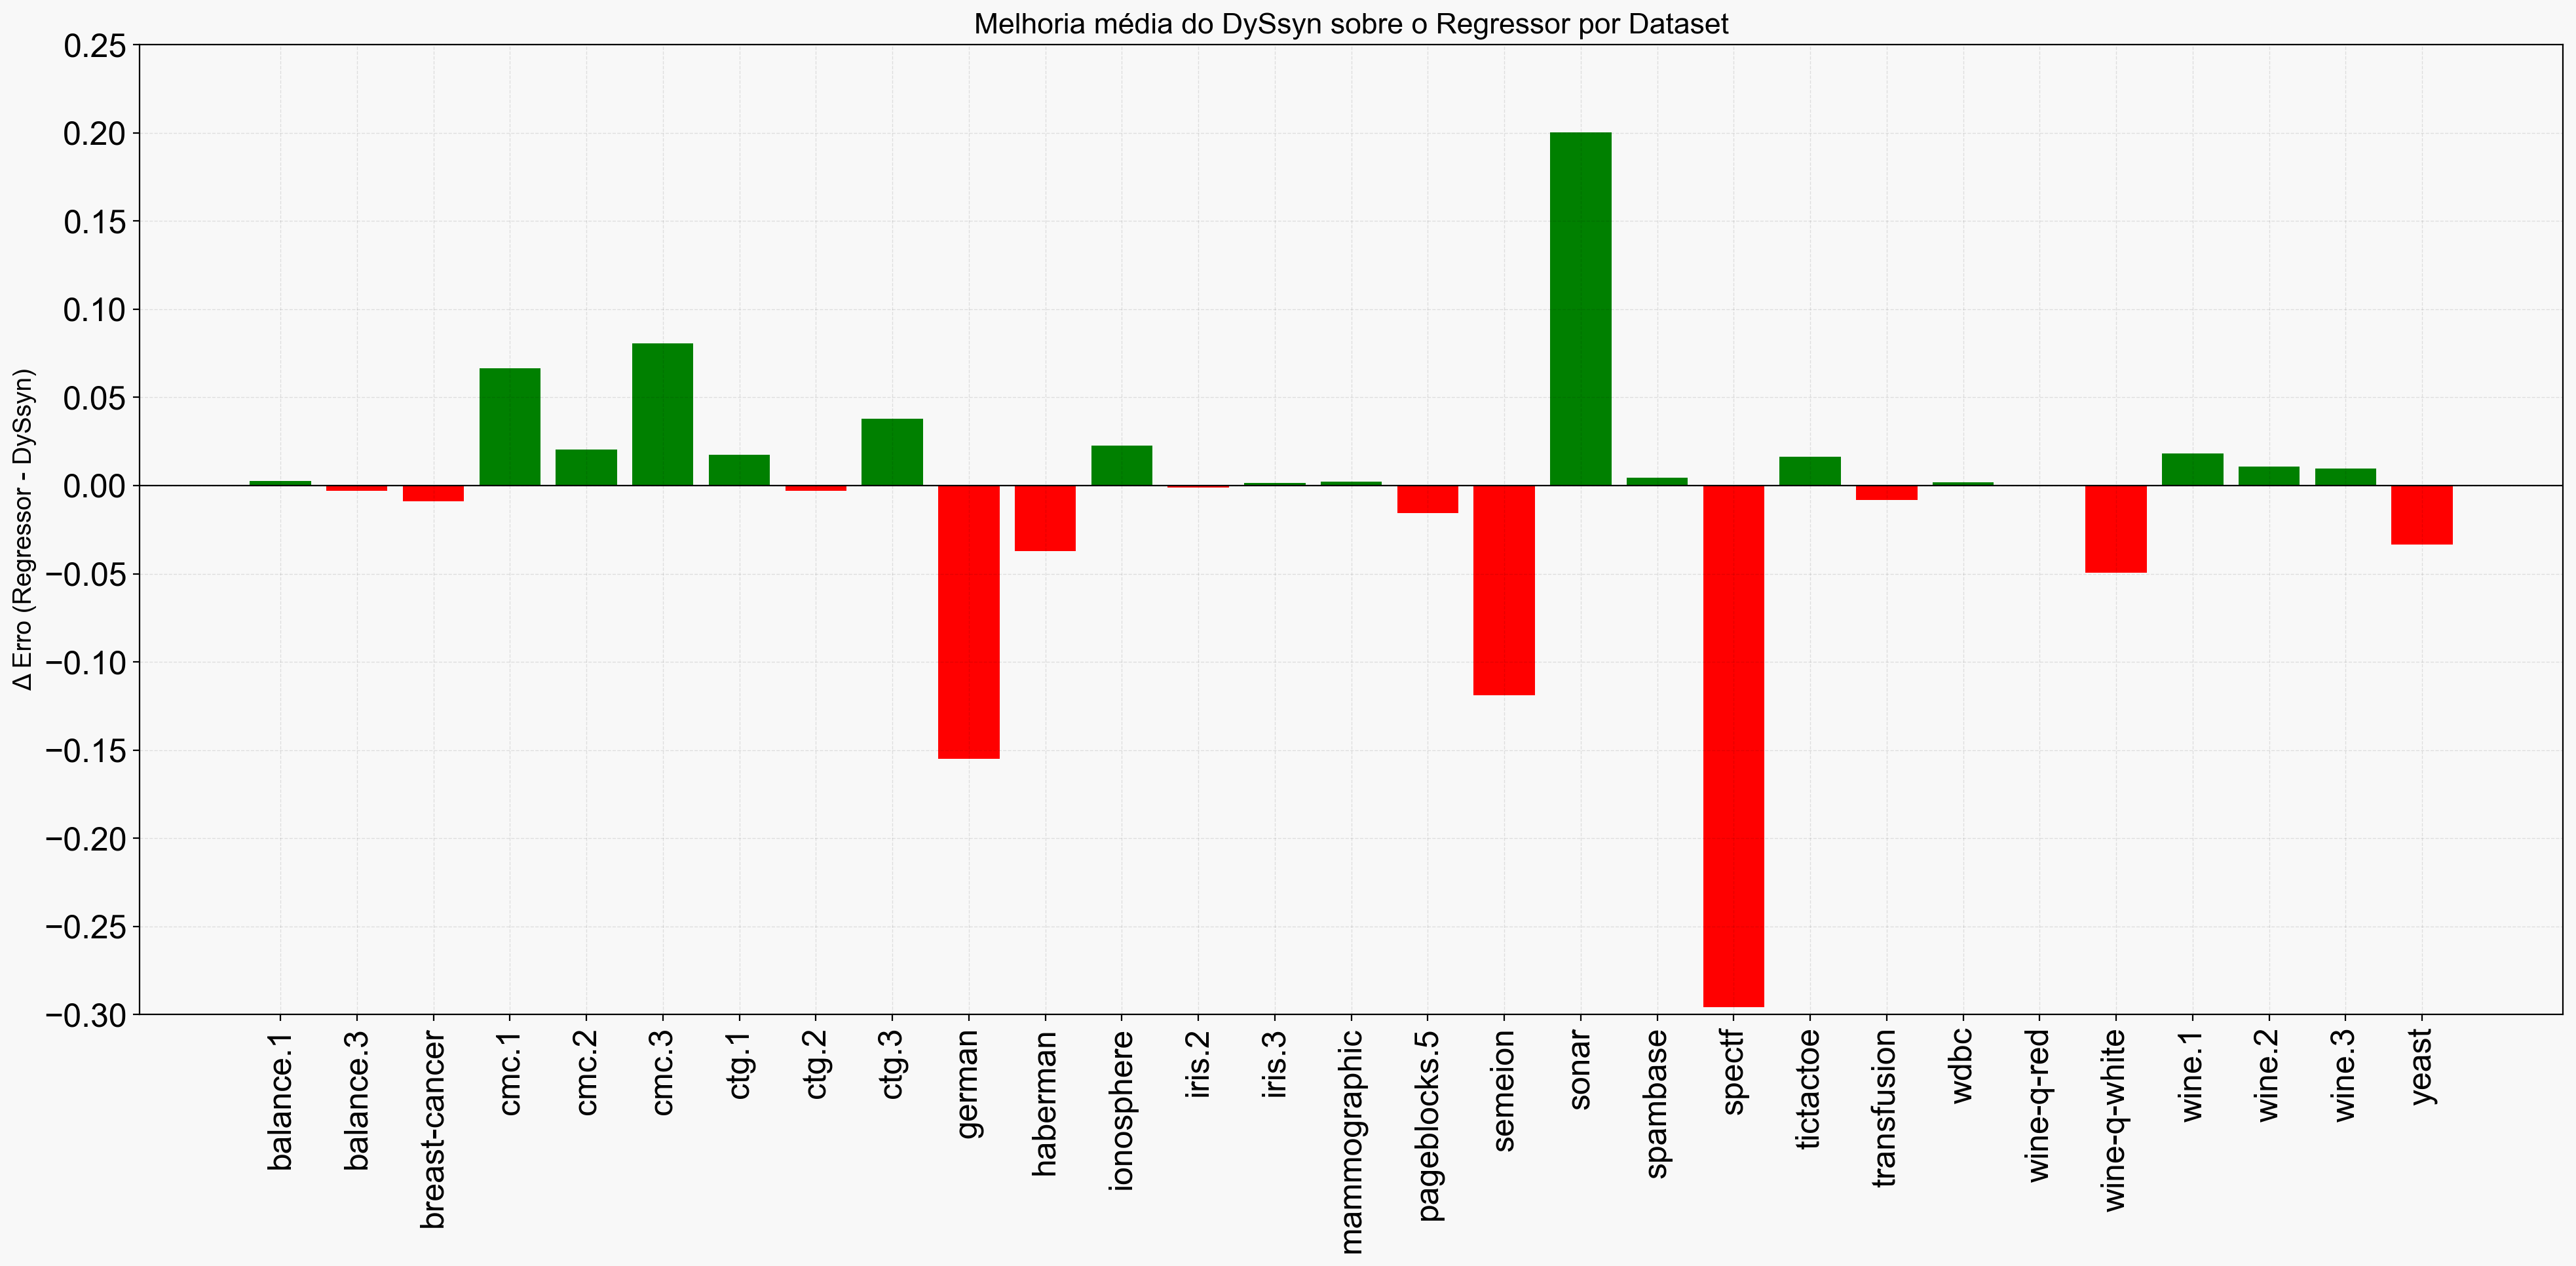

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("resultados_APP_detalhado.csv")

# Calcula a média da diferença por dataset
df_mean = df.groupby("Dataset", as_index=False).agg({
    "Erro_Regressor": "mean",
    "Erro_DySsyn": "mean"
})
df_mean["Diferença"] = df_mean["Erro_Regressor"] - df_mean["Erro_DySsyn"]

plt.figure(figsize=(20,10))
plt.bar(df_mean["Dataset"], df_mean["Diferença"], 
        color=["green" if d > 0 else "red" for d in df_mean["Diferença"]])
plt.xticks(rotation=90)
plt.ylabel("Δ Erro (Regressor - DySsyn)")
plt.title("Melhoria média do DySsyn sobre o Regressor por Dataset")
plt.axhline(0, color="black", linewidth=0.8)

# Define ticks do eixo Y de 0.05 em 0.05
ymin, ymax = plt.ylim()  # pega limites automáticos
plt.yticks(np.arange(-0.5, 0.55, 0.05))
plt.ylim(-0.3, 0.25)

plt.tight_layout()
plt.show()

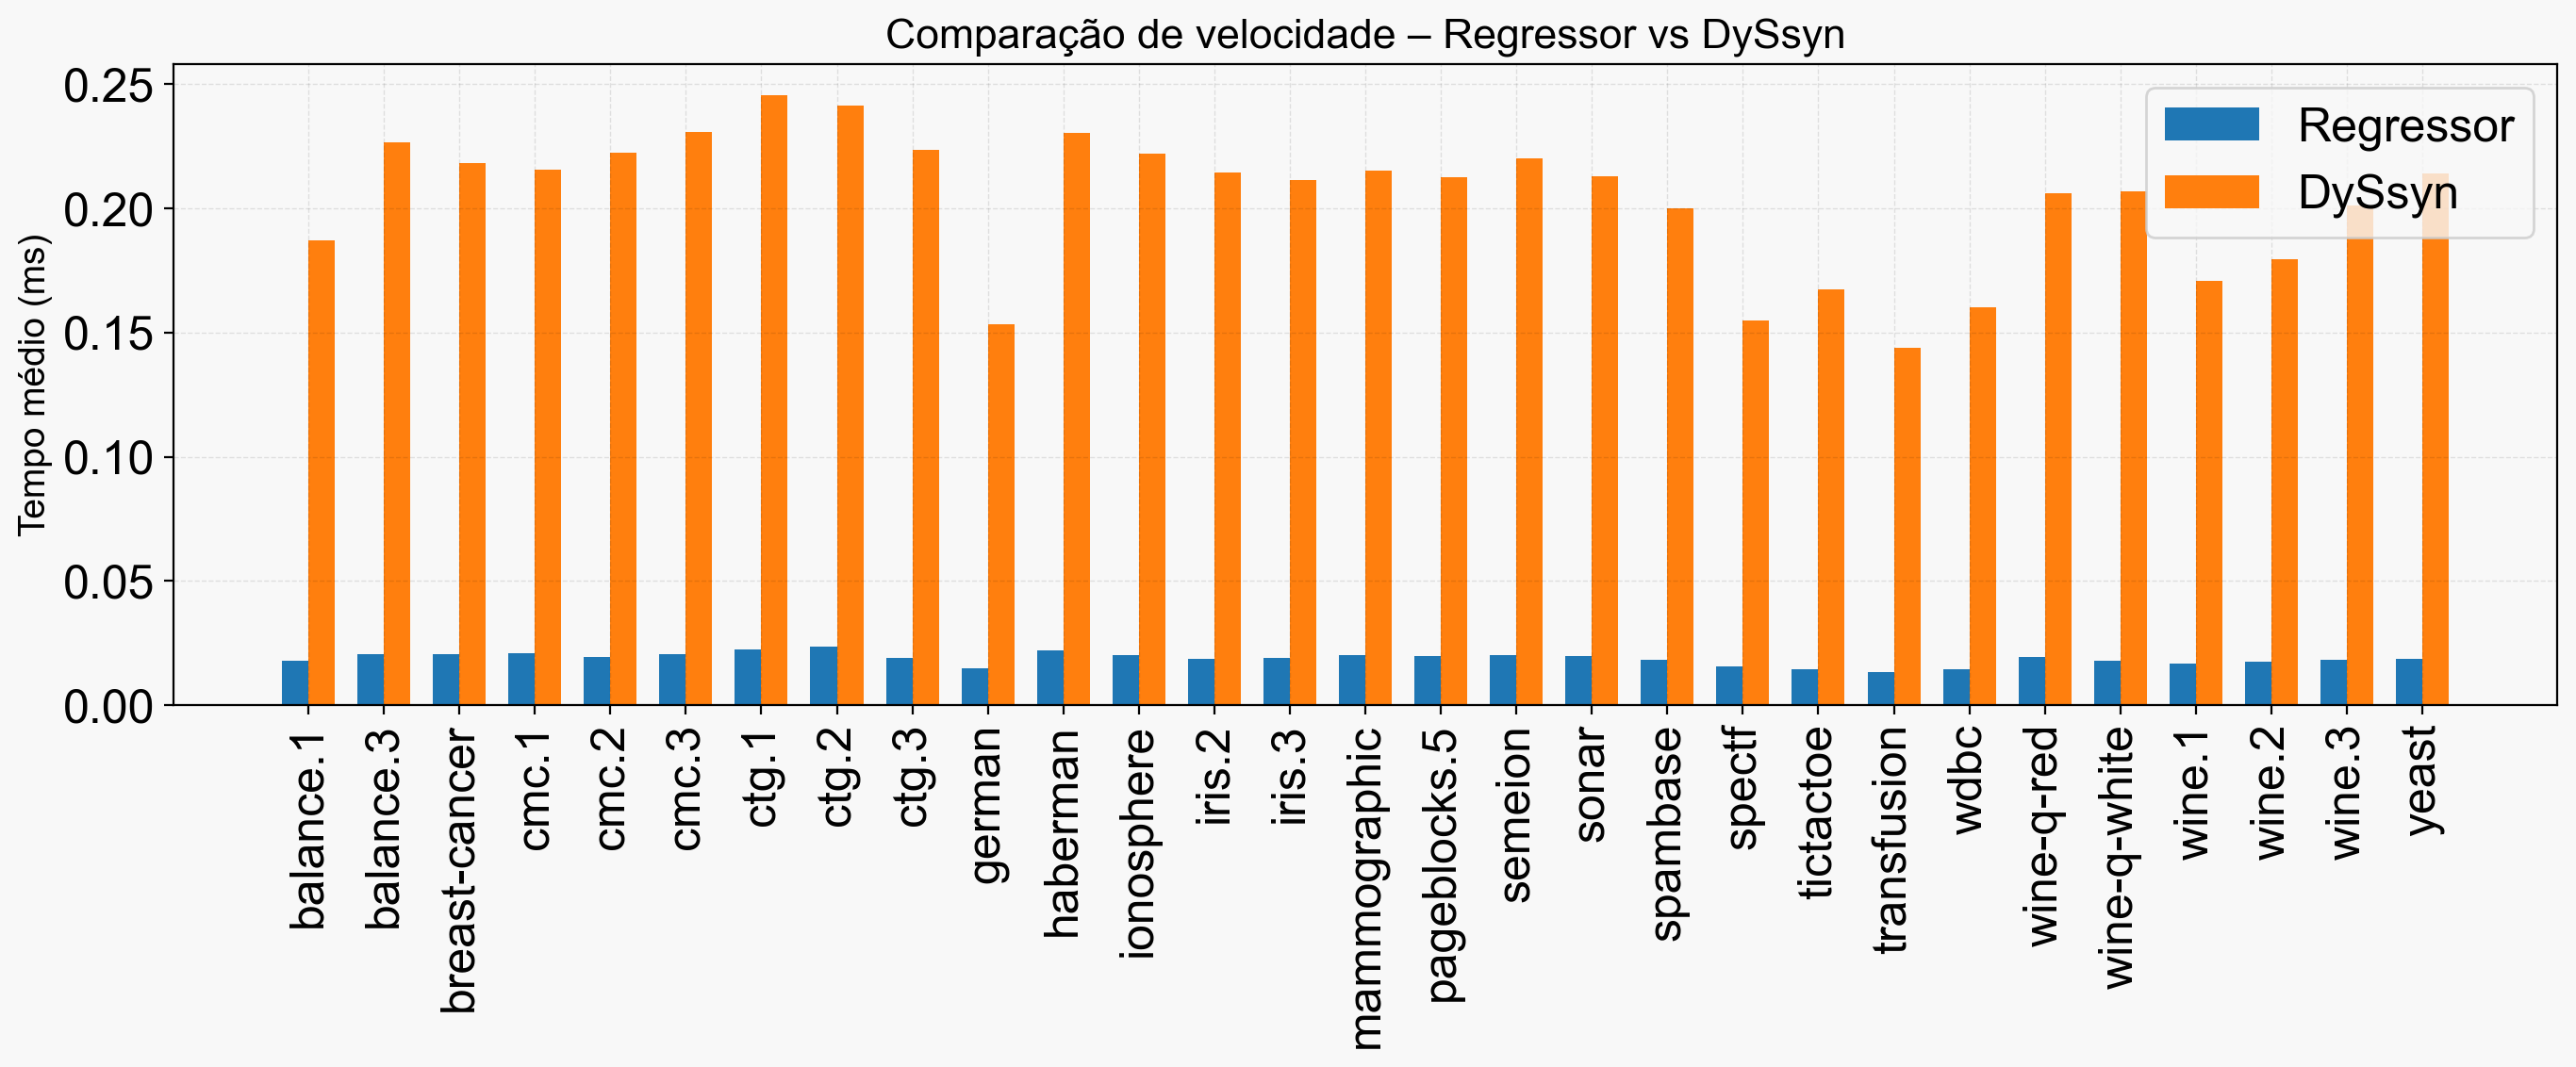

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("resultados_APP_detalhado.csv")

# Agrupar por dataset (média dos tempos)
df_tempo = df.groupby("Dataset")[["Tempo_Médio_Regressor", "Tempo_Médio_DySsyn"]].mean()

# Plot
plt.figure(figsize=(14,6))
x = np.arange(len(df_tempo))
width = 0.35

plt.bar(x - width/2, df_tempo["Tempo_Médio_Regressor"], width, label="Regressor")
plt.bar(x + width/2, df_tempo["Tempo_Médio_DySsyn"], width, label="DySsyn")

plt.xticks(x, df_tempo.index, rotation=90)
plt.ylabel("Tempo médio (ms)")
plt.title("Comparação de velocidade – Regressor vs DySsyn")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# -----------------------------
# Função geradora (já OK)
# -----------------------------
import numpy as np
import pickle
from mlquantify.utils.method import MoSS

def gerar_distribuicoes_moss_duplo(
    n_samples=1000,
    n_prevalences=50,
    n_merges=10,
    n_curves=200,
    save_path="synthetic_distributions.pkl"
):
    alphas = np.linspace(0.01, 0.99, n_prevalences)
    merges = np.linspace(0.0, 1.0, n_merges)
    synthetic_distributions = {}
    total = len(alphas) * len(merges)
    count = 0

    for alpha in alphas:
        for merge in merges:
            all_curves = []
            for _ in range(n_curves):
                syn_pos, syn_neg = MoSS(n_samples, alpha, merge)  # assinatura: (n_samples, alpha, merge)
                syn_scores = np.concatenate([syn_pos, syn_neg])
                all_curves.append(syn_scores)
            # chave é tupla (alpha, merge)
            synthetic_distributions[(round(alpha, 3), round(merge, 3))] = all_curves
            count += 1
            if count % 10 == 0:
                print(f"Progresso: {count}/{total} combinações geradas...")

    with open(save_path, "wb") as f:
        pickle.dump(synthetic_distributions, f)

    print(f"✅ {total} combinações (alpha × merge), cada uma com {n_curves} curvas salvas em {save_path}")
    return synthetic_distributions

# Exemplo de chamada (ajuste conforme sua máquina)
synthetic_distributions = gerar_distribuicoes_moss_duplo(n_samples=1000, n_prevalences=30, n_merges=60, n_curves=100)

Progresso: 10/1800 combinações geradas...
Progresso: 20/1800 combinações geradas...
Progresso: 30/1800 combinações geradas...
Progresso: 40/1800 combinações geradas...
Progresso: 50/1800 combinações geradas...
Progresso: 60/1800 combinações geradas...
Progresso: 70/1800 combinações geradas...
Progresso: 80/1800 combinações geradas...
Progresso: 90/1800 combinações geradas...
Progresso: 100/1800 combinações geradas...
Progresso: 110/1800 combinações geradas...
Progresso: 120/1800 combinações geradas...
Progresso: 130/1800 combinações geradas...
Progresso: 140/1800 combinações geradas...
Progresso: 150/1800 combinações geradas...
Progresso: 160/1800 combinações geradas...
Progresso: 170/1800 combinações geradas...
Progresso: 180/1800 combinações geradas...
Progresso: 190/1800 combinações geradas...
Progresso: 200/1800 combinações geradas...
Progresso: 210/1800 combinações geradas...
Progresso: 220/1800 combinações geradas...
Progresso: 230/1800 combinações geradas...
Progresso: 240/1800 

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, entropy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from mlquantify.methods.aggregative import DySsyn
import quapy as qp
import pickle
import warnings
import time
from typing import Protocol

warnings.filterwarnings("ignore")

# ===========================
# ===== Funções base ========
# ===========================

def extract_features(scores):
    features = {
        'mean': np.mean(scores),
        'var': np.var(scores),
        'skew': skew(scores),
        'kurt': kurtosis(scores),
        'q10': np.quantile(scores, 0.1),
        'q25': np.quantile(scores, 0.25),
        'q50': np.quantile(scores, 0.5),
        'q75': np.quantile(scores, 0.75),
        'q90': np.quantile(scores, 0.9)
    }
    hist, _ = np.histogram(scores, bins=20, density=True)
    hist = hist + 1e-12
    features['entropy'] = entropy(hist)
    return features


def generate_artificial_prevalences(n_dim, n_prev=19, n_iter=1):
    if n_dim != 2:
        raise NotImplementedError("Apenas binário por enquanto.")
    prevalences = np.linspace(0.05, 0.95, n_prev)
    combos = [[1-p, p] for p in prevalences]
    return combos * n_iter


def get_indexes_with_prevalence(y, prevalence, batch_size):
    pos_idx = np.where(y == 1)[0]
    neg_idx = np.where(y == 0)[0]
    n_pos = int(batch_size * prevalence[1])
    n_neg = batch_size - n_pos
    pos_sel = np.random.choice(pos_idx, size=n_pos, replace=True)
    neg_sel = np.random.choice(neg_idx, size=n_neg, replace=True)
    idx = np.concatenate([pos_sel, neg_sel])
    np.random.shuffle(idx)
    return idx


class APP(Protocol):
    def __init__(self, batch_size, n_prevalences, repeats=1, random_state=None):
        self.batch_size = batch_size if isinstance(batch_size, list) else [batch_size]
        self.n_prevalences = n_prevalences
        self.repeats = repeats
        self.random_state = random_state
        if random_state is not None:
            np.random.seed(random_state)

    def split(self, X, y):
        n_dim = len(np.unique(y))
        for batch_size in self.batch_size:
            prevalences = generate_artificial_prevalences(n_dim, self.n_prevalences, self.repeats)
            for prev in prevalences:
                idx = get_indexes_with_prevalence(y, prev, batch_size)
                yield idx, prev


# ===========================
# ===== Treino Regressor ====
# ===========================

with open("synthetic_distributions.pkl", "rb") as f:
    synthetic_distributions = pickle.load(f)

X_features, y_labels = [], []
for key, curves in synthetic_distributions.items():
    all_scores = np.concatenate(curves) if isinstance(curves, list) else curves
    feats = extract_features(all_scores)
    X_features.append(list(feats.values()))

    if isinstance(key, tuple):
        y_labels.append(key[0])  # alpha
    else:
        y_labels.append(key)

X_features = np.array(X_features)
y_labels = np.array(y_labels)

reg = RandomForestRegressor(n_estimators=300, random_state=42)
reg.fit(X_features, y_labels)


# ===========================
# ===== Avaliação APP =======
# ===========================

def avaliar_dataset_APP(nome, X, y, app_protocol):
    if len(np.unique(y)) > 2:
        y = (y == np.max(y)).astype(int)

    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.5, random_state=42, stratify=y
    )

    clf = RandomForestClassifier(n_estimators=300, random_state=42)
    clf.fit(X_train, y_train)

    dyssin_model = DySsyn(RandomForestClassifier(n_estimators=300, random_state=42))
    dyssin_model.fit(X_train, y_train)

    resultados = []
    tempos_regressor = []
    tempos_dyssyn = []

    for idx, prev in app_protocol.split(X_test, y_test):
        X_batch, y_batch = X_test[idx], y_test[idx]
        real_prev = np.mean(y_batch)
        scores = clf.predict_proba(X_batch)[:, 1]

        # === Tempo Regressor ===
        feats = np.array(list(extract_features(scores).values())).reshape(1, -1)
        t0 = time.perf_counter()
        pred_prev_reg = reg.predict(feats)[0]
        t_reg = time.perf_counter() - t0

        # === Tempo DySsyn ===
        t0 = time.perf_counter()
        pred_prev_dyssin = dyssin_model.predict(X_batch)[1]
        t_dys = time.perf_counter() - t0

        tempos_regressor.append(t_reg)
        tempos_dyssyn.append(t_dys)

        resultados.append({
            "Dataset": nome,
            "Prev_Real": real_prev,
            "Prev_Alvo": prev[1],
            "Regressor": pred_prev_reg,
            "DySsyn": pred_prev_dyssin,
            "Erro_Regressor": abs(real_prev - pred_prev_reg),
            "Erro_DySsyn": abs(real_prev - pred_prev_dyssin),
            "Tempo_Regressor": t_reg,
            "Tempo_DySsyn": t_dys
        })

    df = pd.DataFrame(resultados)
    df["Tempo_Médio_Regressor"] = np.mean(tempos_regressor)
    df["Tempo_Médio_DySsyn"] = np.mean(tempos_dyssyn)
    return df


# ===========================
# ===== Rodar Experimentos ===
# ===========================

datasets_names = [
    "balance.1", "balance.3", "breast-cancer",
    "cmc.1", "cmc.2", "cmc.3", "ctg.1", "ctg.2", "ctg.3", "german",
    "haberman", "ionosphere", "iris.2", "iris.3", "mammographic",
    "pageblocks.5", "semeion", "sonar", "spambase", "spectf",
    "tictactoe", "transfusion", "wdbc", "wine.1", "wine.2",
    "wine.3", "wine-q-red", "wine-q-white", "yeast"
]

app = APP(batch_size=200, n_prevalences=19, repeats=2, random_state=42)

resultados_detalhados = []
resumo_final = []

for nome in datasets_names:
    try:
        print(f"\n🔍 Carregando dataset QuaPy: {nome}")
        dataset = qp.datasets.fetch_UCIBinaryDataset(nome)

        X_train, y_train = dataset.training.X, dataset.training.y
        X_test, y_test = dataset.test.X, dataset.test.y

        X = np.vstack([X_train, X_test])
        y = np.concatenate([y_train, y_test])
        X = np.array(X)
        y = np.array(y).ravel()

        print(f"✅ Rodando APP no dataset {nome}")
        df_app = avaliar_dataset_APP(nome, X, y, app)

        resultados_detalhados.append(df_app)

        mean_errors = df_app[["Erro_Regressor", "Erro_DySsyn"]].mean()
        mean_times = df_app[["Tempo_Regressor", "Tempo_DySsyn"]].mean()

        resumo_final.append({
            "Dataset": nome,
            "Erro Médio Regressor": mean_errors["Erro_Regressor"],
            "Erro Médio DySsyn": mean_errors["Erro_DySsyn"],
            "Tempo Médio Regressor (s)": mean_times["Tempo_Regressor"],
            "Tempo Médio DySsyn (s)": mean_times["Tempo_DySsyn"]
        })

    except Exception as e:
        print(f"❌ Erro no dataset {nome}: {e}")

# ---- Salvar ----
df_detalhado = pd.concat(resultados_detalhados, ignore_index=True)
df_resumo = pd.DataFrame(resumo_final)

df_detalhado.to_csv("resultados_APP_detalhado.csv", index=False)
df_resumo.to_csv("resultados_APP_resumo.csv", index=False)

print("\n===== RESULTADOS SALVOS =====")
print("📄 resultados_APP_detalhado.csv → 1 linha por prevalência")
print("📄 resultados_APP_resumo.csv → 1 linha por dataset (média dos erros e tempos)")


🔍 Carregando dataset QuaPy: balance.1
✅ Rodando APP no dataset balance.1

🔍 Carregando dataset QuaPy: balance.3
✅ Rodando APP no dataset balance.3

🔍 Carregando dataset QuaPy: breast-cancer
✅ Rodando APP no dataset breast-cancer

🔍 Carregando dataset QuaPy: cmc.1
✅ Rodando APP no dataset cmc.1

🔍 Carregando dataset QuaPy: cmc.2
✅ Rodando APP no dataset cmc.2

🔍 Carregando dataset QuaPy: cmc.3
✅ Rodando APP no dataset cmc.3

🔍 Carregando dataset QuaPy: ctg.1
✅ Rodando APP no dataset ctg.1

🔍 Carregando dataset QuaPy: ctg.2
✅ Rodando APP no dataset ctg.2

🔍 Carregando dataset QuaPy: ctg.3
✅ Rodando APP no dataset ctg.3

🔍 Carregando dataset QuaPy: german
✅ Rodando APP no dataset german

🔍 Carregando dataset QuaPy: haberman
✅ Rodando APP no dataset haberman

🔍 Carregando dataset QuaPy: ionosphere
✅ Rodando APP no dataset ionosphere

🔍 Carregando dataset QuaPy: iris.2
✅ Rodando APP no dataset iris.2

🔍 Carregando dataset QuaPy: iris.3
✅ Rodando APP no dataset iris.3

🔍 Carregando dataset 

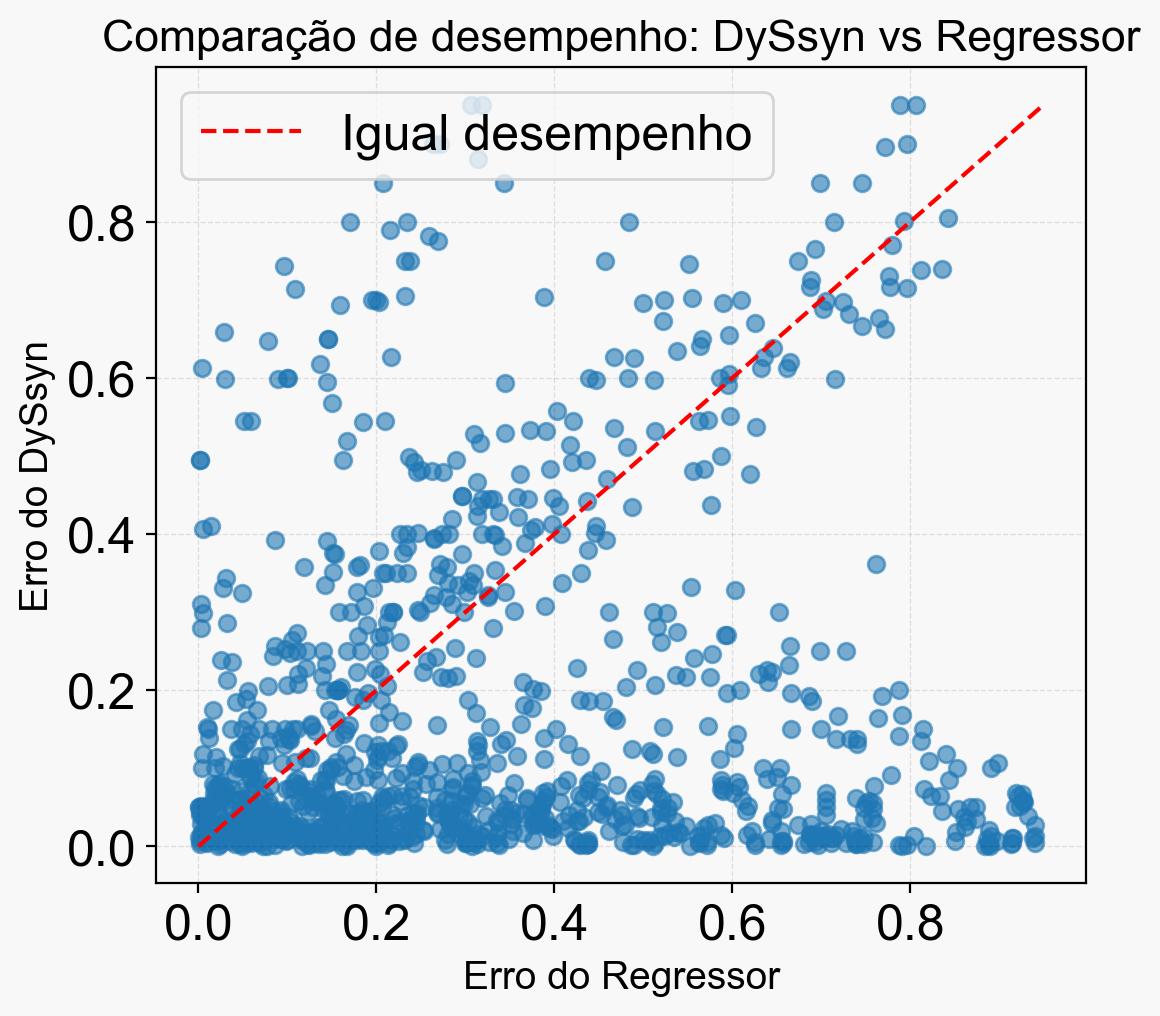

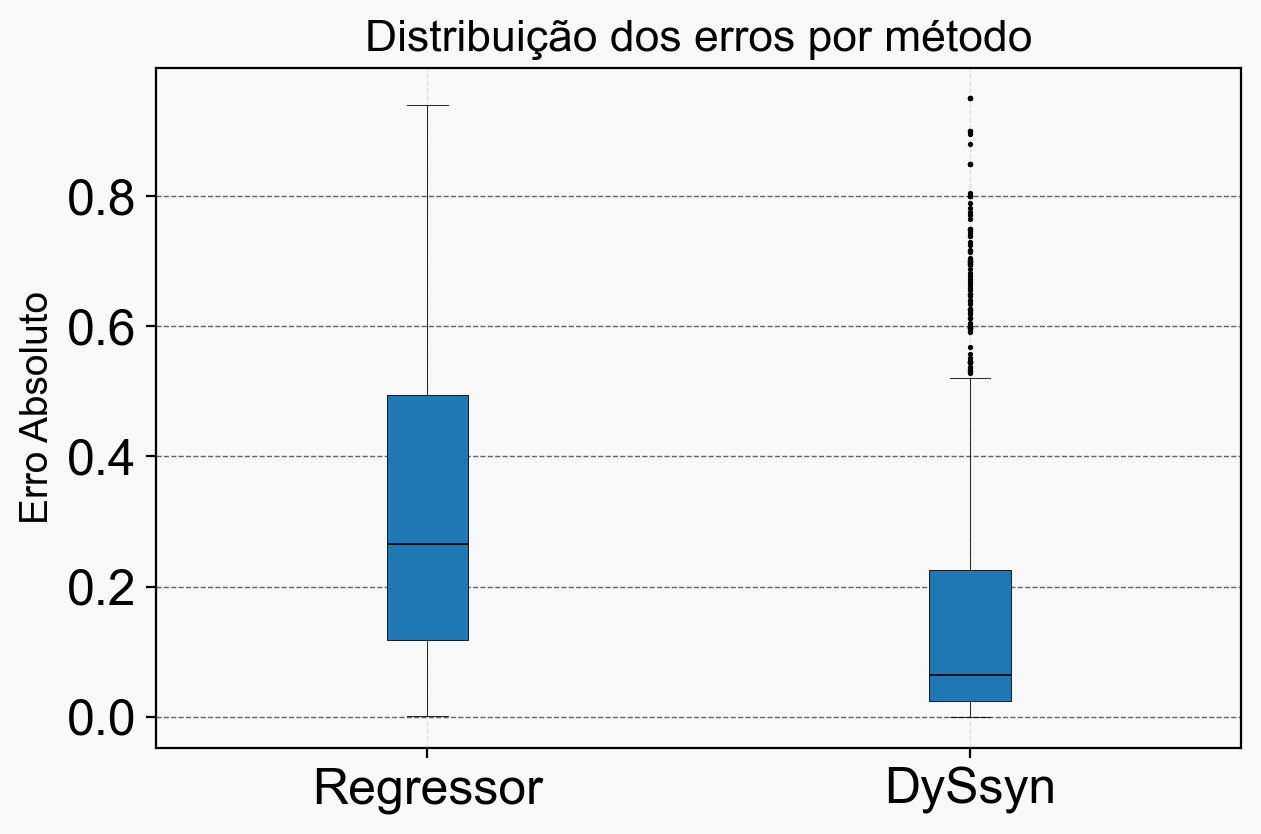

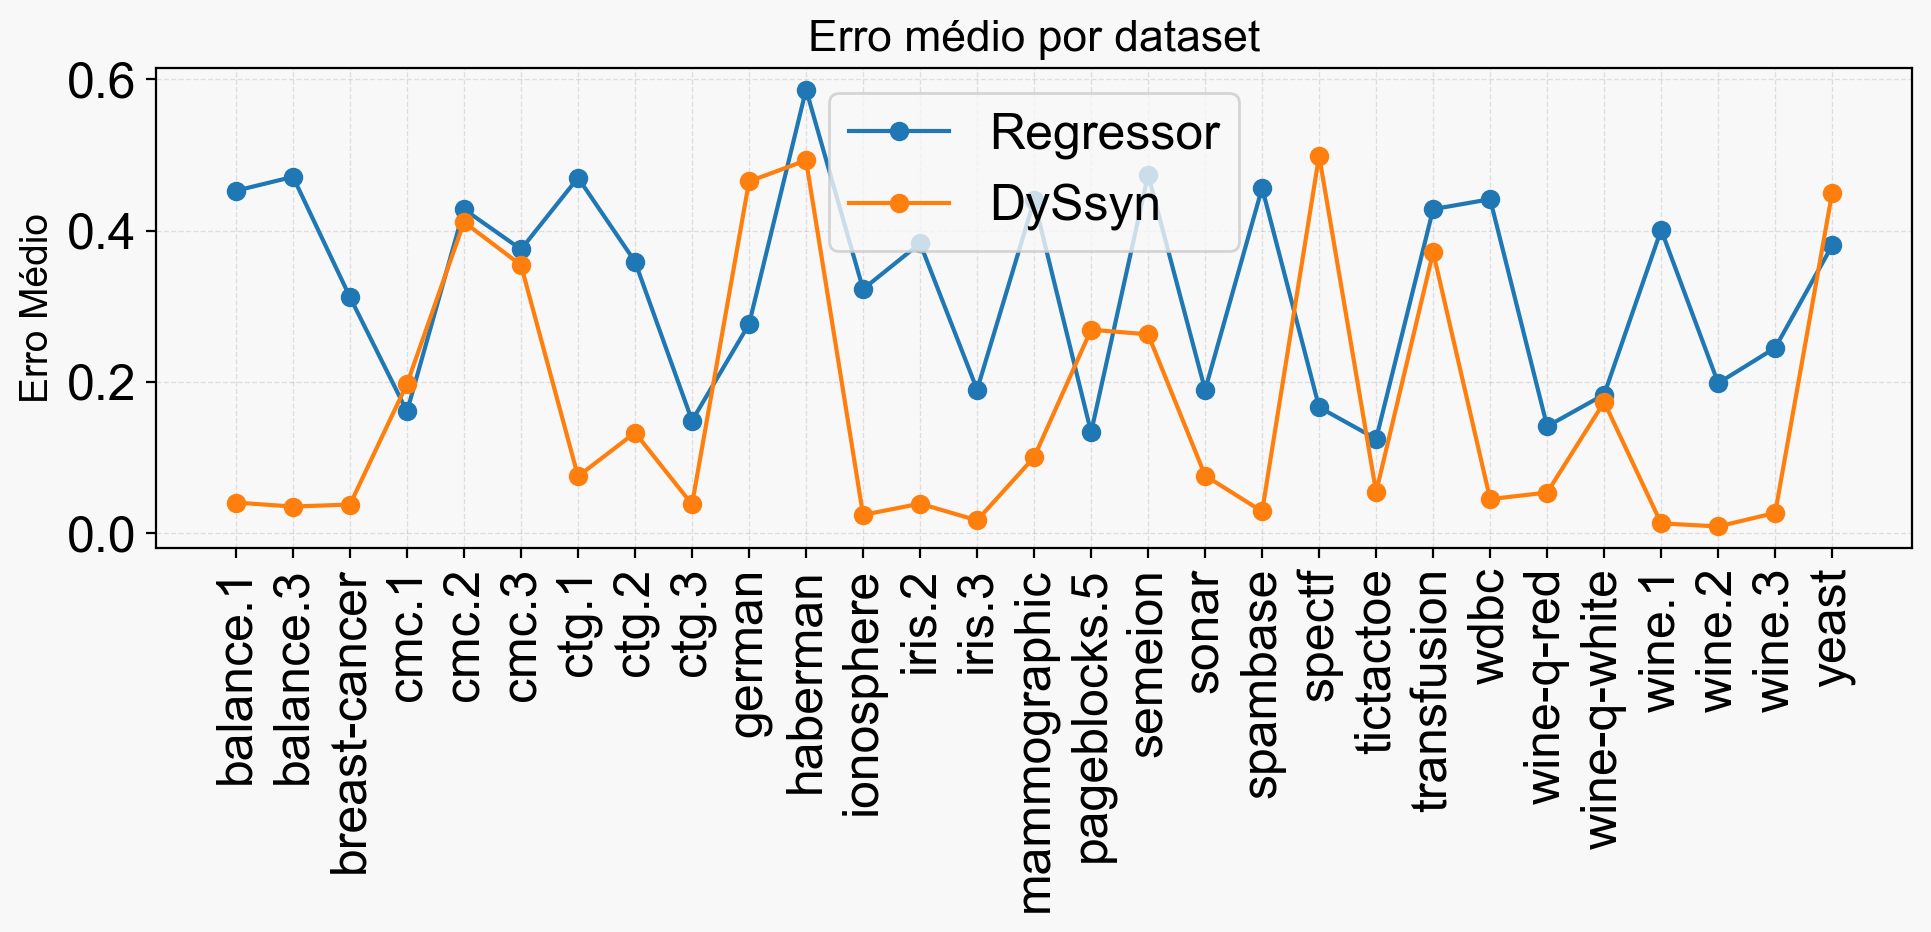

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Lê o CSV gerado anteriormente
resultados_app_detalhado = pd.read_csv("resultados_APP_detalhado.csv")

# --- 1️⃣ Dispersão Regressor vs DySsyn ---
plt.figure(figsize=(6,6))
plt.scatter(
    resultados_app_detalhado['Erro_Regressor'],
    resultados_app_detalhado['Erro_DySsyn'],
    alpha=0.6
)
plt.plot(
    [0, resultados_app_detalhado[['Erro_Regressor','Erro_DySsyn']].values.max()],
    [0, resultados_app_detalhado[['Erro_Regressor','Erro_DySsyn']].values.max()],
    'r--', label='Igual desempenho'
)
plt.xlabel('Erro do Regressor')
plt.ylabel('Erro do DySsyn')
plt.title('Comparação de desempenho: DySsyn vs Regressor')
plt.legend()
plt.grid(True)
plt.show()


# --- 2️⃣ Boxplot comparando distribuições ---
plt.figure(figsize=(7,5))
plt.boxplot(
    [resultados_app_detalhado['Erro_Regressor'], resultados_app_detalhado['Erro_DySsyn']],
    labels=['Regressor', 'DySsyn'],
    patch_artist=True
)
plt.ylabel('Erro Absoluto')
plt.title('Distribuição dos erros por método')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()


# --- 3️⃣ Médias por dataset ---
df_medias = resultados_app_detalhado.groupby("Dataset")[["Erro_Regressor","Erro_DySsyn"]].mean().reset_index()

plt.figure(figsize=(10,5))
plt.plot(df_medias["Dataset"], df_medias["Erro_Regressor"], 'o-', label="Regressor")
plt.plot(df_medias["Dataset"], df_medias["Erro_DySsyn"], 'o-', label="DySsyn")
plt.xticks(rotation=90)
plt.ylabel("Erro Médio")
plt.title("Erro médio por dataset")
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
# -----------------------------
# Função geradora (já OK)
# -----------------------------
import numpy as np
import pickle
from mlquantify.utils.method import MoSS

def gerar_distribuicoes_moss_duplo(
    n_samples=1000,
    n_prevalences=50,
    n_merges=10,
    n_curves=200,
    save_path="synthetic_distributions.pkl"
):
    alphas = np.linspace(0.01, 0.99, n_prevalences)
    merges = np.linspace(0.0, 1.0, n_merges)
    synthetic_distributions = {}
    total = len(alphas) * len(merges)
    count = 0

    for alpha in alphas:
        for merge in merges:
            all_curves = []
            for _ in range(n_curves):
                syn_pos, syn_neg = MoSS(n_samples, alpha, merge)  # assinatura: (n_samples, alpha, merge)
                syn_scores = np.concatenate([syn_pos, syn_neg])
                all_curves.append(syn_scores)
            # chave é tupla (alpha, merge)
            synthetic_distributions[(round(alpha, 3), round(merge, 3))] = all_curves
            count += 1
            if count % 10 == 0:
                print(f"Progresso: {count}/{total} combinações geradas...")

    with open(save_path, "wb") as f:
        pickle.dump(synthetic_distributions, f)

    print(f"✅ {total} combinações (alpha × merge), cada uma com {n_curves} curvas salvas em {save_path}")
    return synthetic_distributions

# Exemplo de chamada (ajuste conforme sua máquina)
synthetic_distributions = gerar_distribuicoes_moss_duplo(n_samples=1000, n_prevalences=30, n_merges=60, n_curves=100)

Progresso: 10/1800 combinações geradas...
Progresso: 20/1800 combinações geradas...
Progresso: 30/1800 combinações geradas...
Progresso: 40/1800 combinações geradas...
Progresso: 50/1800 combinações geradas...
Progresso: 60/1800 combinações geradas...
Progresso: 70/1800 combinações geradas...
Progresso: 80/1800 combinações geradas...
Progresso: 90/1800 combinações geradas...
Progresso: 100/1800 combinações geradas...
Progresso: 110/1800 combinações geradas...
Progresso: 120/1800 combinações geradas...
Progresso: 130/1800 combinações geradas...
Progresso: 140/1800 combinações geradas...
Progresso: 150/1800 combinações geradas...
Progresso: 160/1800 combinações geradas...
Progresso: 170/1800 combinações geradas...
Progresso: 180/1800 combinações geradas...
Progresso: 190/1800 combinações geradas...
Progresso: 200/1800 combinações geradas...
Progresso: 210/1800 combinações geradas...
Progresso: 220/1800 combinações geradas...
Progresso: 230/1800 combinações geradas...
Progresso: 240/1800 

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, entropy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from mlquantify.methods.aggregative import DySsyn
import quapy as qp
import pickle
import warnings
import time
from typing import Protocol

warnings.filterwarnings("ignore")

# ===========================
# ===== Funções base ========
# ===========================

def extract_features(scores):
    features = {
        'mean': np.mean(scores),
        'var': np.var(scores),
        'skew': skew(scores),
        'kurt': kurtosis(scores),
        'q10': np.quantile(scores, 0.1),
        'q25': np.quantile(scores, 0.25),
        'q50': np.quantile(scores, 0.5),
        'q75': np.quantile(scores, 0.75),
        'q90': np.quantile(scores, 0.9)
    }
    hist, _ = np.histogram(scores, bins=20, density=True)
    hist = hist + 1e-12
    features['entropy'] = entropy(hist)
    return features


def generate_artificial_prevalences(n_dim, n_prev=19, n_iter=1):
    if n_dim != 2:
        raise NotImplementedError("Apenas binário por enquanto.")
    prevalences = np.linspace(0.05, 0.95, n_prev)
    combos = [[1-p, p] for p in prevalences]
    return combos * n_iter


def get_indexes_with_prevalence(y, prevalence, batch_size):
    pos_idx = np.where(y == 1)[0]
    neg_idx = np.where(y == 0)[0]
    n_pos = int(batch_size * prevalence[1])
    n_neg = batch_size - n_pos
    pos_sel = np.random.choice(pos_idx, size=n_pos, replace=True)
    neg_sel = np.random.choice(neg_idx, size=n_neg, replace=True)
    idx = np.concatenate([pos_sel, neg_sel])
    np.random.shuffle(idx)
    return idx


class APP(Protocol):
    def __init__(self, batch_size, n_prevalences, repeats=1, random_state=None):
        self.batch_size = batch_size if isinstance(batch_size, list) else [batch_size]
        self.n_prevalences = n_prevalences
        self.repeats = repeats
        self.random_state = random_state
        if random_state is not None:
            np.random.seed(random_state)

    def split(self, X, y):
        n_dim = len(np.unique(y))
        for batch_size in self.batch_size:
            prevalences = generate_artificial_prevalences(n_dim, self.n_prevalences, self.repeats)
            for prev in prevalences:
                idx = get_indexes_with_prevalence(y, prev, batch_size)
                yield idx, prev


# ===========================
# ===== Treino Regressor ====
# ===========================

with open("synthetic_distributions.pkl", "rb") as f:
    synthetic_distributions = pickle.load(f)

X_features, y_labels = [], []
for key, curves in synthetic_distributions.items():
    all_scores = np.concatenate(curves) if isinstance(curves, list) else curves
    feats = extract_features(all_scores)
    X_features.append(list(feats.values()))

    if isinstance(key, tuple):
        y_labels.append(key[0])  # alpha
    else:
        y_labels.append(key)

X_features = np.array(X_features)
y_labels = np.array(y_labels)

reg = RandomForestRegressor(n_estimators=300, random_state=42)
reg.fit(X_features, y_labels)


# ===========================
# ===== Avaliação APP =======
# ===========================

def avaliar_dataset_APP(nome, X, y, app_protocol):
    if len(np.unique(y)) > 2:
        y = (y == np.max(y)).astype(int)

    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.5, random_state=42, stratify=y
    )

    clf = RandomForestClassifier(n_estimators=300, random_state=42)
    clf.fit(X_train, y_train)

    dyssin_model = DySsyn(RandomForestClassifier(n_estimators=300, random_state=42))
    dyssin_model.fit(X_train, y_train)

    resultados = []
    tempos_regressor = []
    tempos_dyssyn = []

    for idx, prev in app_protocol.split(X_test, y_test):
        X_batch, y_batch = X_test[idx], y_test[idx]
        real_prev = np.mean(y_batch)
        scores = clf.predict_proba(X_batch)[:, 1]

        # === Tempo Regressor ===
        feats = np.array(list(extract_features(scores).values())).reshape(1, -1)
        t0 = time.perf_counter()
        pred_prev_reg = reg.predict(feats)[0]
        t_reg = time.perf_counter() - t0

        # === Tempo DySsyn ===
        t0 = time.perf_counter()
        pred_prev_dyssin = dyssin_model.predict(X_batch)[1]
        t_dys = time.perf_counter() - t0

        tempos_regressor.append(t_reg)
        tempos_dyssyn.append(t_dys)

        resultados.append({
            "Dataset": nome,
            "Prev_Real": real_prev,
            "Prev_Alvo": prev[1],
            "Regressor": pred_prev_reg,
            "DySsyn": pred_prev_dyssin,
            "Erro_Regressor": abs(real_prev - pred_prev_reg),
            "Erro_DySsyn": abs(real_prev - pred_prev_dyssin),
            "Tempo_Regressor": t_reg,
            "Tempo_DySsyn": t_dys
        })

    df = pd.DataFrame(resultados)
    df["Tempo_Médio_Regressor"] = np.mean(tempos_regressor)
    df["Tempo_Médio_DySsyn"] = np.mean(tempos_dyssyn)
    return df


# ===========================
# ===== Rodar Experimentos ===
# ===========================

datasets_names = [
    "balance.1", "balance.3", "breast-cancer",
    "cmc.1", "cmc.2", "cmc.3", "ctg.1", "ctg.2", "ctg.3", "german",
    "haberman", "ionosphere", "iris.2", "iris.3", "mammographic",
    "pageblocks.5", "semeion", "sonar", "spambase", "spectf",
    "tictactoe", "transfusion", "wdbc", "wine.1", "wine.2",
    "wine.3", "wine-q-red", "wine-q-white", "yeast"
]

app = APP(batch_size=200, n_prevalences=19, repeats=2, random_state=42)

resultados_detalhados = []
resumo_final = []

for nome in datasets_names:
    try:
        print(f"\n🔍 Carregando dataset QuaPy: {nome}")
        dataset = qp.datasets.fetch_UCIBinaryDataset(nome)

        X_train, y_train = dataset.training.X, dataset.training.y
        X_test, y_test = dataset.test.X, dataset.test.y

        X = np.vstack([X_train, X_test])
        y = np.concatenate([y_train, y_test])
        X = np.array(X)
        y = np.array(y).ravel()

        print(f"✅ Rodando APP no dataset {nome}")
        df_app = avaliar_dataset_APP(nome, X, y, app)

        resultados_detalhados.append(df_app)

        mean_errors = df_app[["Erro_Regressor", "Erro_DySsyn"]].mean()
        mean_times = df_app[["Tempo_Regressor", "Tempo_DySsyn"]].mean()

        resumo_final.append({
            "Dataset": nome,
            "Erro Médio Regressor": mean_errors["Erro_Regressor"],
            "Erro Médio DySsyn": mean_errors["Erro_DySsyn"],
            "Tempo Médio Regressor (s)": mean_times["Tempo_Regressor"],
            "Tempo Médio DySsyn (s)": mean_times["Tempo_DySsyn"]
        })

    except Exception as e:
        print(f"❌ Erro no dataset {nome}: {e}")

# ---- Salvar ----
df_detalhado = pd.concat(resultados_detalhados, ignore_index=True)
df_resumo = pd.DataFrame(resumo_final)

df_detalhado.to_csv("resultados_APP_detalhado.csv", index=False)
df_resumo.to_csv("resultados_APP_resumo.csv", index=False)

print("\n===== RESULTADOS SALVOS =====")
print("📄 resultados_APP_detalhado.csv → 1 linha por prevalência")
print("📄 resultados_APP_resumo.csv → 1 linha por dataset (média dos erros e tempos)")


🔍 Carregando dataset QuaPy: balance.1
✅ Rodando APP no dataset balance.1

🔍 Carregando dataset QuaPy: balance.3
✅ Rodando APP no dataset balance.3

🔍 Carregando dataset QuaPy: breast-cancer
✅ Rodando APP no dataset breast-cancer

🔍 Carregando dataset QuaPy: cmc.1
✅ Rodando APP no dataset cmc.1

🔍 Carregando dataset QuaPy: cmc.2
✅ Rodando APP no dataset cmc.2

🔍 Carregando dataset QuaPy: cmc.3
✅ Rodando APP no dataset cmc.3

🔍 Carregando dataset QuaPy: ctg.1
✅ Rodando APP no dataset ctg.1

🔍 Carregando dataset QuaPy: ctg.2
✅ Rodando APP no dataset ctg.2

🔍 Carregando dataset QuaPy: ctg.3
✅ Rodando APP no dataset ctg.3

🔍 Carregando dataset QuaPy: german
✅ Rodando APP no dataset german

🔍 Carregando dataset QuaPy: haberman
✅ Rodando APP no dataset haberman

🔍 Carregando dataset QuaPy: ionosphere
✅ Rodando APP no dataset ionosphere

🔍 Carregando dataset QuaPy: iris.2
✅ Rodando APP no dataset iris.2

🔍 Carregando dataset QuaPy: iris.3
✅ Rodando APP no dataset iris.3

🔍 Carregando dataset 

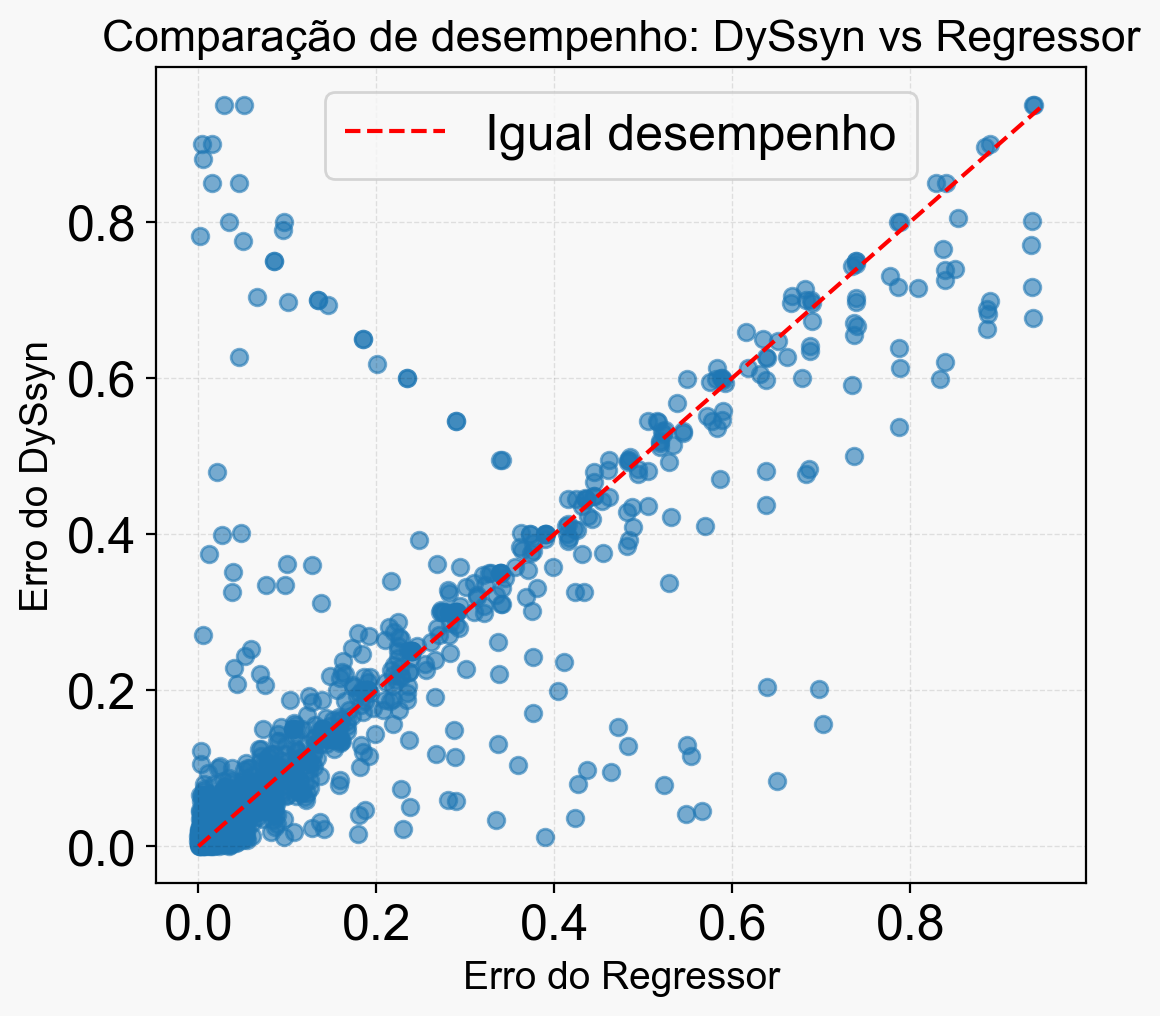

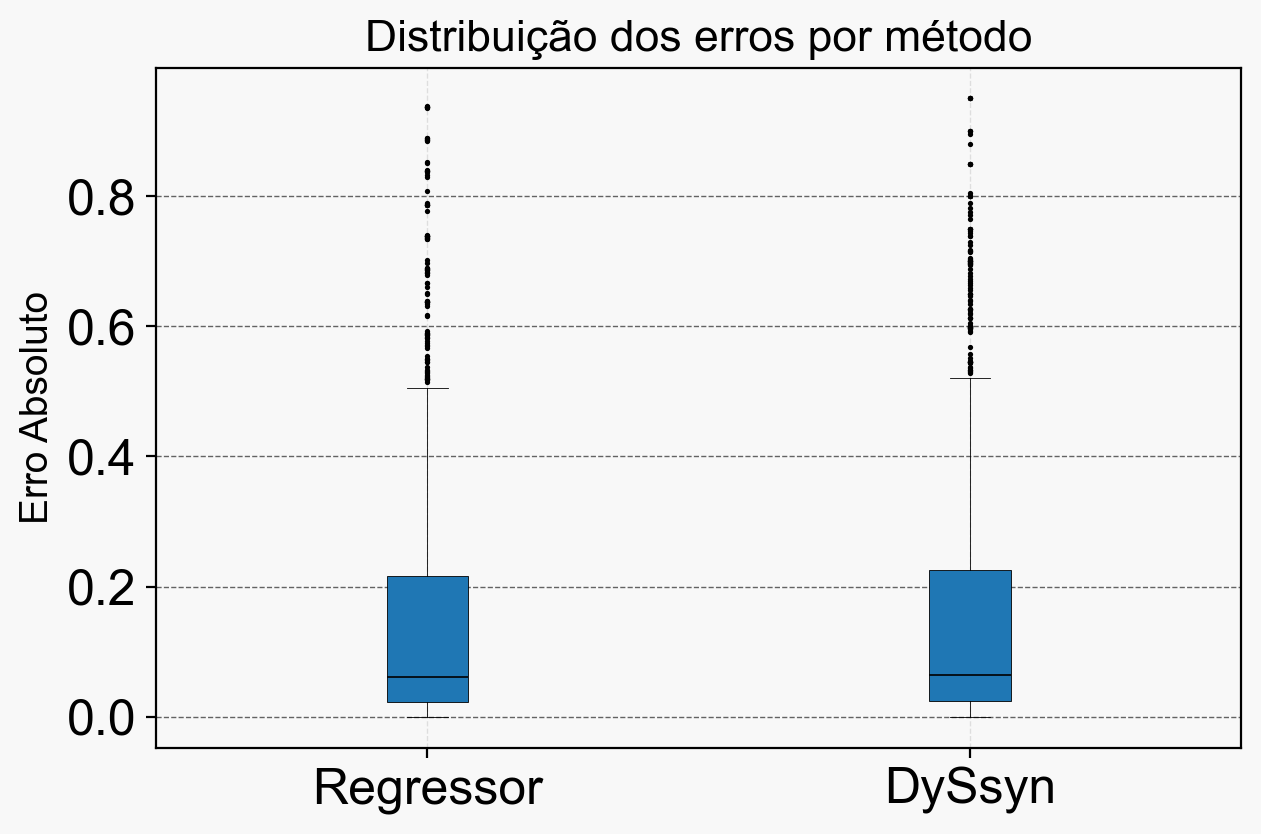

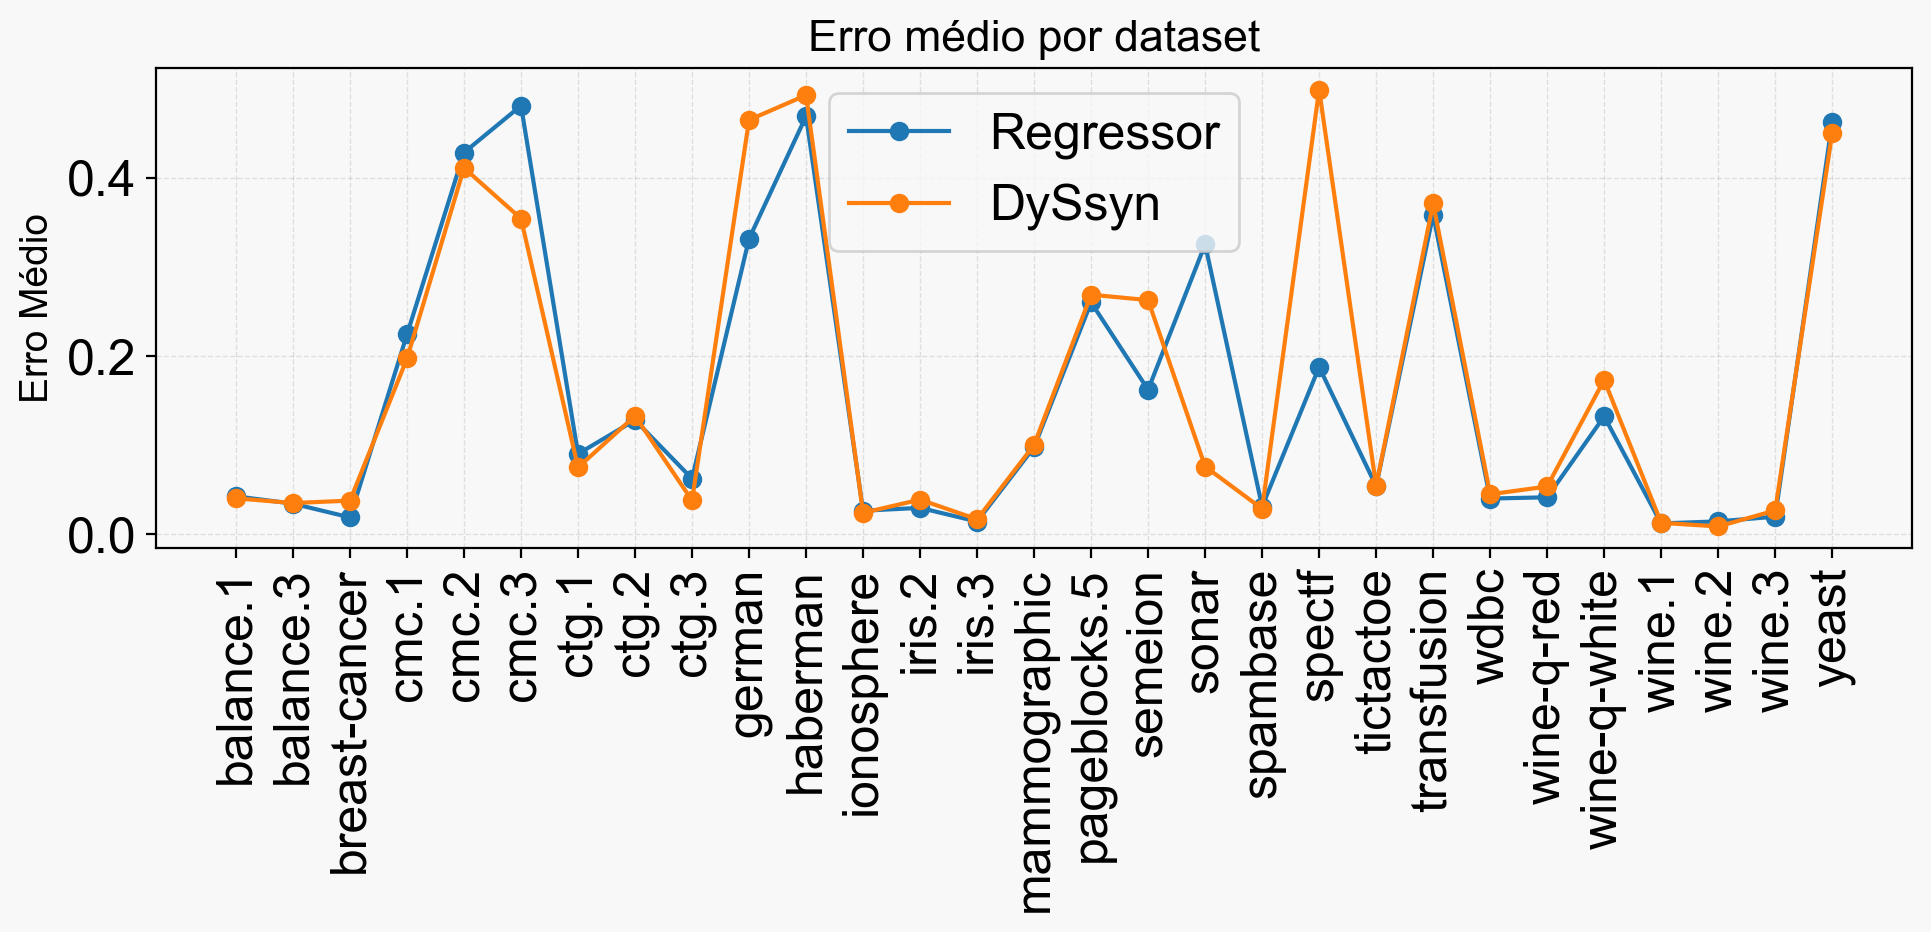

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Lê o CSV gerado anteriormente
resultados_app_detalhado = pd.read_csv("resultados_APP_detalhado.csv")

# --- 1️⃣ Dispersão Regressor vs DySsyn ---
plt.figure(figsize=(6,6))
plt.scatter(
    resultados_app_detalhado['Erro_Regressor'],
    resultados_app_detalhado['Erro_DySsyn'],
    alpha=0.6
)
plt.plot(
    [0, resultados_app_detalhado[['Erro_Regressor','Erro_DySsyn']].values.max()],
    [0, resultados_app_detalhado[['Erro_Regressor','Erro_DySsyn']].values.max()],
    'r--', label='Igual desempenho'
)
plt.xlabel('Erro do Regressor')
plt.ylabel('Erro do DySsyn')
plt.title('Comparação de desempenho: DySsyn vs Regressor')
plt.legend()
plt.grid(True)
plt.show()


# --- 2️⃣ Boxplot comparando distribuições ---
plt.figure(figsize=(7,5))
plt.boxplot(
    [resultados_app_detalhado['Erro_Regressor'], resultados_app_detalhado['Erro_DySsyn']],
    labels=['Regressor', 'DySsyn'],
    patch_artist=True
)
plt.ylabel('Erro Absoluto')
plt.title('Distribuição dos erros por método')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()


# --- 3️⃣ Médias por dataset ---
df_medias = resultados_app_detalhado.groupby("Dataset")[["Erro_Regressor","Erro_DySsyn"]].mean().reset_index()

plt.figure(figsize=(10,5))
plt.plot(df_medias["Dataset"], df_medias["Erro_Regressor"], 'o-', label="Regressor")
plt.plot(df_medias["Dataset"], df_medias["Erro_DySsyn"], 'o-', label="DySsyn")
plt.xticks(rotation=90)
plt.ylabel("Erro Médio")
plt.title("Erro médio por dataset")
plt.legend()
plt.tight_layout()
plt.show()

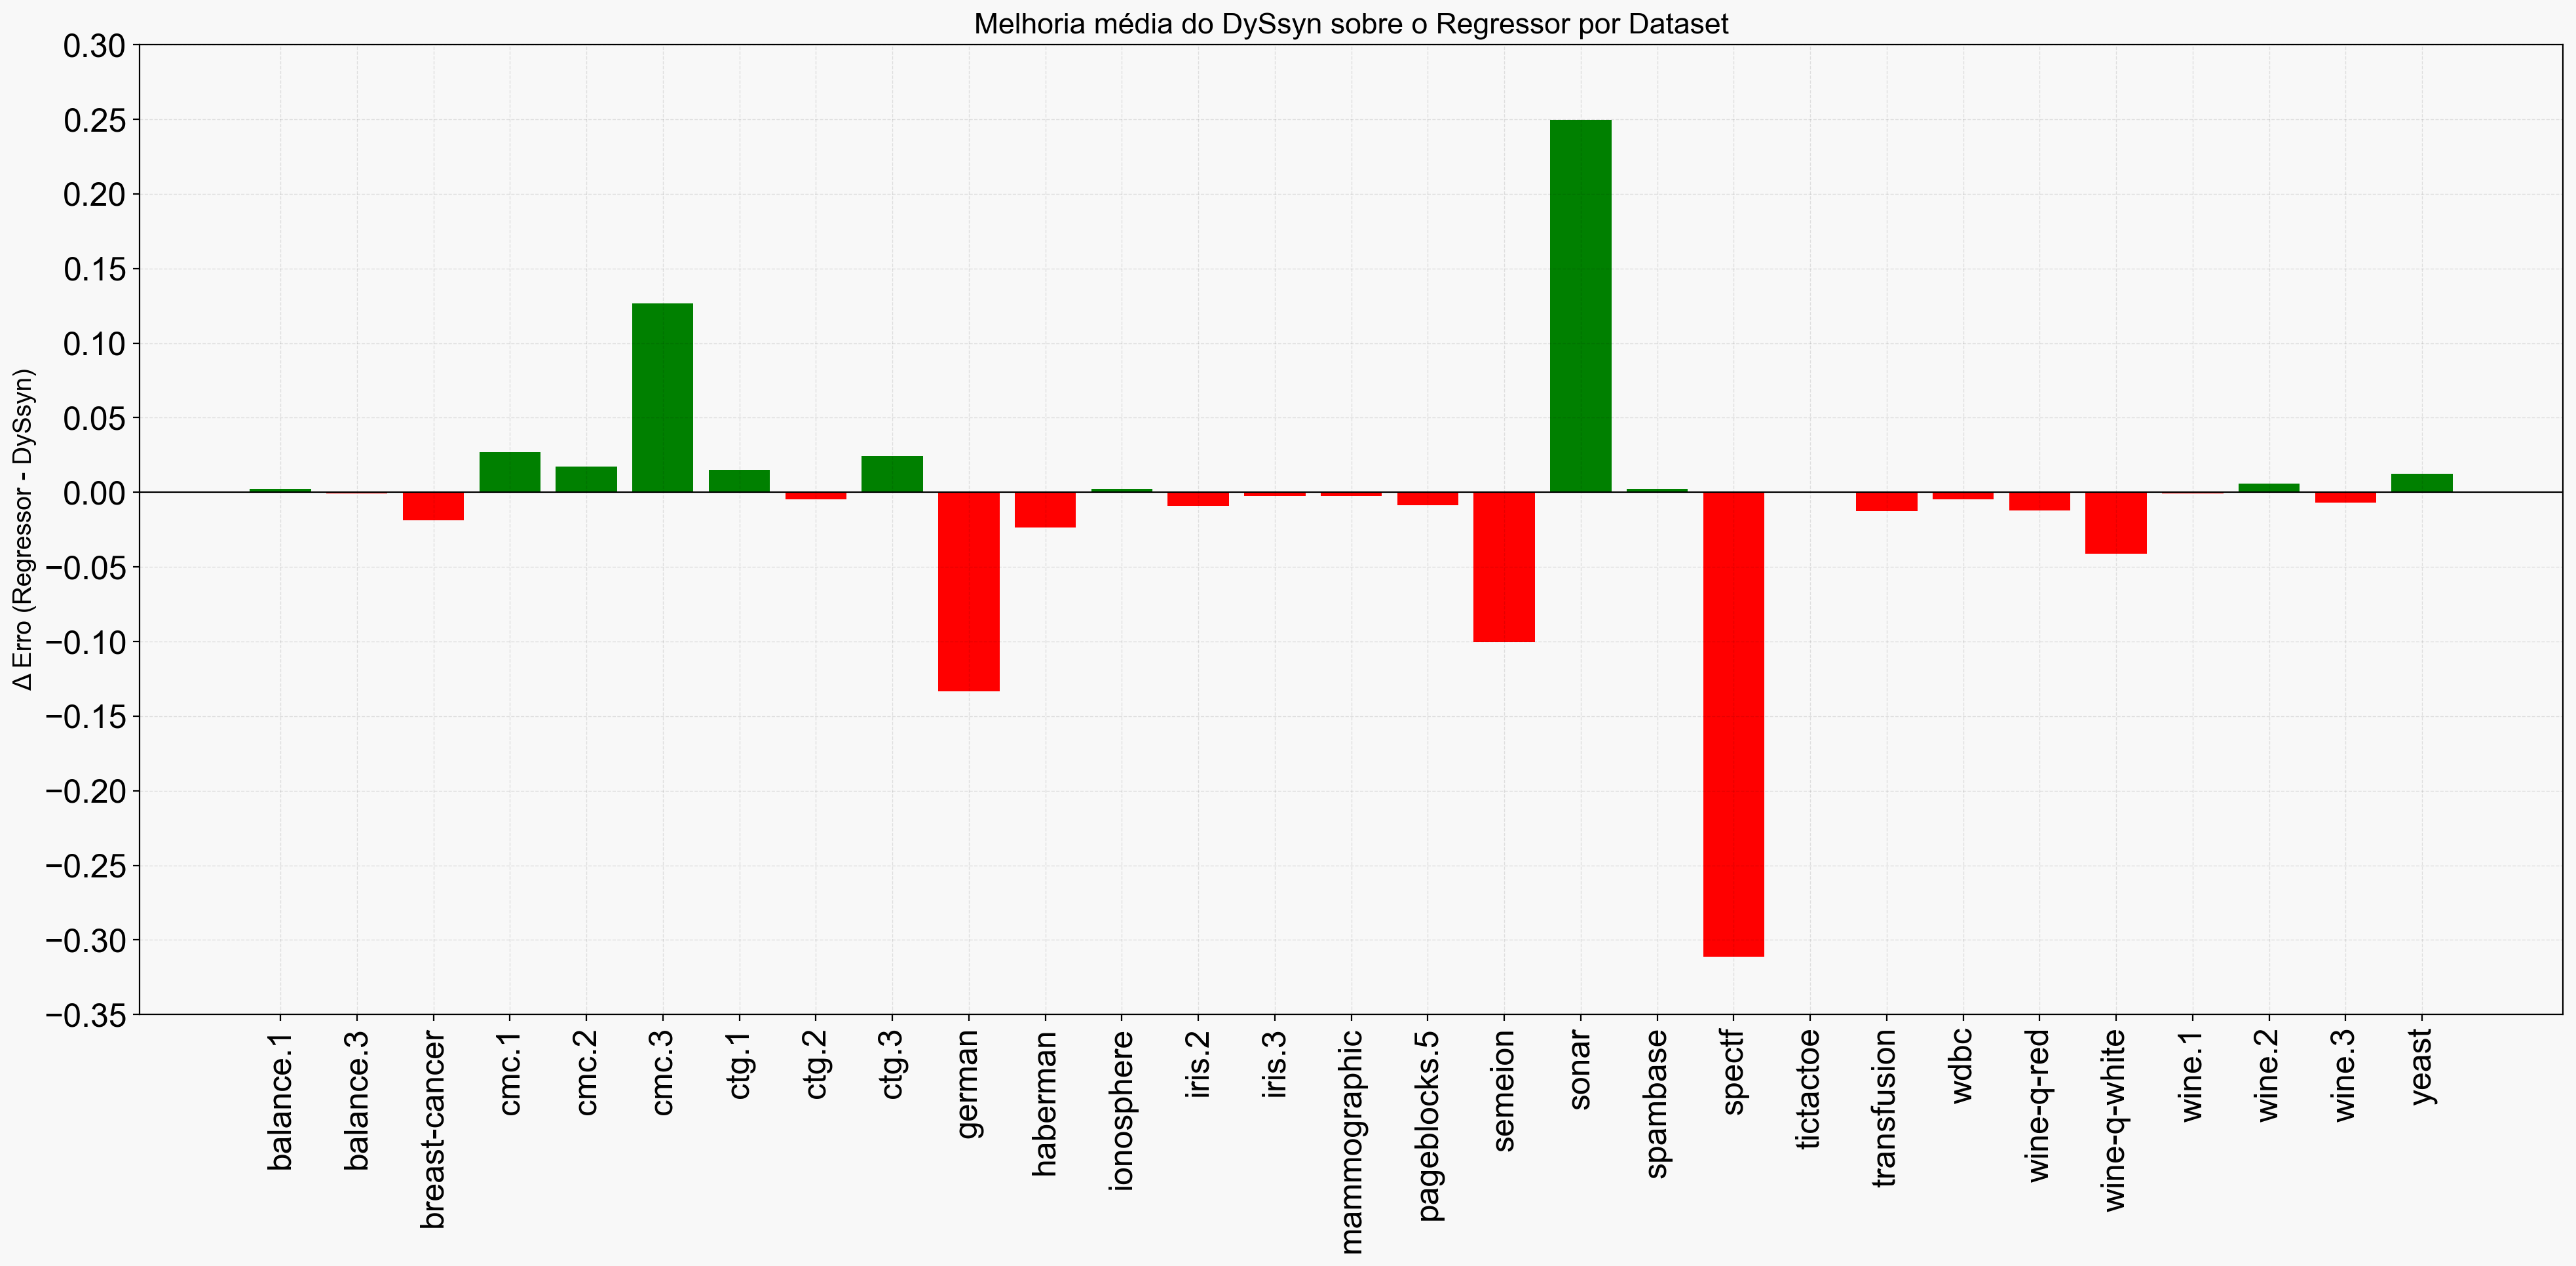

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("resultados_APP_detalhado.csv")

# Calcula a média da diferença por dataset
df_mean = df.groupby("Dataset", as_index=False).agg({
    "Erro_Regressor": "mean",
    "Erro_DySsyn": "mean"
})
df_mean["Diferença"] = df_mean["Erro_Regressor"] - df_mean["Erro_DySsyn"]

plt.figure(figsize=(20,10))
plt.bar(df_mean["Dataset"], df_mean["Diferença"], 
        color=["green" if d > 0 else "red" for d in df_mean["Diferença"]])
plt.xticks(rotation=90)
plt.ylabel("Δ Erro (Regressor - DySsyn)")
plt.title("Melhoria média do DySsyn sobre o Regressor por Dataset")
plt.axhline(0, color="black", linewidth=0.8)

# Define ticks do eixo Y de 0.05 em 0.05
ymin, ymax = plt.ylim()  # pega limites automáticos
plt.yticks(np.arange(-0.5, 0.55, 0.05))
plt.ylim(-0.35, 0.30)

plt.tight_layout()
plt.show()